# Imports

In [2]:
# -- Data & Plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bar
from tqdm import tqdm, tnrange, tqdm_notebook
tqdm.pandas()

# -- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
PandasTools.RenderImagesInAllDataFrames()
print("RDKit Version: ", rdkit.__version__)

RDKit Version:  2024.03.5


In [3]:
# This will allow us to see all columns:
pd.set_option("display.max_columns", 100)

# To disable it, do:
# pd.reset_option("^display")

# To get details:
pd.get_option("display.max_columns")

# More information at:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#getting-and-setting-options

100

# Obtaining the database
Today we will be working with a database of compounds that wre somehow tested against the 
human cycloxoygenase-2 ([COX-2](https://en.wikipedia.org/wiki/Cyclooxygenase-2)), 
which is involved in pain and inflammation processes.
NSAIDS that selectively target COX-2 ([coxibs](https://en.wikipedia.org/wiki/Cyclooxygenase-2_inhibitor)) 
reduce the risk of peptic ulcers associated with the inhibition of a related enzyme, 
[COX-1](https://en.wikipedia.org/wiki/Cyclooxygenase-1).

We can obtain a database of compounds tested against COX-2 by searching different databases, 
the main ones being [PubChem](https://pubchem.ncbi.nlm.nih.gov/), maintained by the NIH,
and [ChEMBL](https://www.ebi.ac.uk/chembl/), maintained by the European Bioinformatics Institute.

Here, we will work with compounds obtained from the ChEMBL database. The process to obtain the database is the following:
1. Navigate to the [ChEMBL](https://www.ebi.ac.uk/chembl/) site, and search for "COX-2", **but don't hit enter yet!**
2. From the drop-down list, under "Targets", select "COX-2". That will return a page with different "COX-2" targets
3. Scroll down to the human COX-2 (CHEMBL230):
<a href="https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL230/"><img src="./media/ChEMBL_COX-2.png" border=1 /></a> <br>
Clicking on the header will take you to the page with COX-2 data.
4. Finally,scroll to **"Activity Charts"**, and click on the **"Activity Types for CHEMBL230 (Cyclooxygenase-2)"** link:
<a href="https://www.ebi.ac.uk/chembl/web_components/explore/activities/STATE_ID:A7tQ9Eh8n8uuiWNfvBq-yw%3D%3D"><img src="./media/ChEMBL_COX-2_activities.png" border=1 /></a> <br>
It will take you to a list of 13,999 compounds (as of 08/28/2024) with measured activity against COX-2, 
which you can download as a CSV file by clicking the <img src="./media/ChEMBL_CSV.png" alt="CSV" /> button. 


<div class="alert alert-info" role="alert">
    Note: It may take a while. To speed up our class, the file is already available here in the data folder: `data/ChEMBL_COX-2_2024-08-28.csv`.
</div>


And we're ready to start exploring!

# Exploring the database
The CSV file from ChEMBL has a weird format, with ";" separating the columnns!

In [4]:
cox2db = pd.read_csv("data/ChEMBL_COX-2_2024-08-28.csv", sep=";")
cox2db.head(5)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL1200623,ETHYLESTRENOL,4.0,288.48,1.0,5.09,ETHYLESTRENOL,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,0,CHEMBL1909131,DRUGMATRIX: Cyclooxygenase COX-2 enzyme inhibi...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,Sf21,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL4106362,NaN,NaN,NaN
1,CHEMBL404811,DIGITONIN,NaN,1229.32,NaN,NaN,DIGITONIN,C[C@@H]1CC[C@@]2(OC1)O[C@H]1[C@@H](O)[C@H]3[C@...,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,0,CHEMBL1909131,DRUGMATRIX: Cyclooxygenase COX-2 enzyme inhibi...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,Sf21,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL4106362,NaN,NaN,NaN
2,CHEMBL416126,NaN,NaN,388.39,0.0,4.43,20j,CS(=O)(=O)c1ccc(-c2cc(F)c(F)cc2-c2ccc3c(c2)OCO...,IC50,'=',12.00,nM,7.92,NaN,NaN,UO_0000065,20.39,0.40,3.49,15.06,0,CHEMBL762917,In vitro inhibitory activity against human rec...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1129066,1,Scientific Literature,J Med Chem,1996.0,NaN,NaN,NaN,NaN
3,CHEMBL1413,CICLOPIROX,4.0,207.27,0.0,2.44,CICLOPIROX,Cc1cc(C2CCCCC2)n(O)c(=O)c1,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,0,CHEMBL1909131,DRUGMATRIX: Cyclooxygenase COX-2 enzyme inhibi...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,Sf21,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL4106362,NaN,NaN,NaN
4,CHEMBL143776,NaN,NaN,321.37,1.0,5.99,32,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3C2)cc1,IC50,'=',0.08,nM,10.10,NaN,NaN,UO_0000065,31.42,0.57,4.11,63.94,0,CHEMBL769655,Tested in vitro for inhibition against Prostag...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1133534,1,Scientific Literature,J Med Chem,2000.0,NaN,NaN,NaN,NaN


That's a lot of stuff. This is the list of columns available:

In [5]:
cox2db.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'Standard Text Value'],
 

In [6]:
cox2db.shape

(13999, 47)

# Unique molecules

The database has a total of 13,999 *entries*, which were collected from diverse sources. How many are really unique? We can check by the `ChEMBL ID`, which is an unique identifier for each molecule: 

In [7]:
len(cox2db['Molecule ChEMBL ID'].unique())

8582

From the total of 13,999 entries, only 8,582 have unique IDs. 

Furthermore, if we check the SMILES representations:

In [8]:
len(cox2db['Smiles'].unique())

8545

There seems to be some molecules with different IDs but the same SMILES!

Let's look at the repetitions of molecules with the same ID:

In [9]:
id_counts = cox2db['Molecule ChEMBL ID'].value_counts()
id_counts

Molecule ChEMBL ID
CHEMBL118        291
CHEMBL6          172
CHEMBL122         83
CHEMBL521         52
CHEMBL7162        36
                ... 
CHEMBL2105059      1
CHEMBL1201338      1
CHEMBL521686       1
CHEMBL708          1
CHEMBL1697733      1
Name: count, Length: 8582, dtype: int64

Some molecules appear in various experiments. For example, Celecoxib ([CHEMBL118](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL118/)) is a reference in many studies.

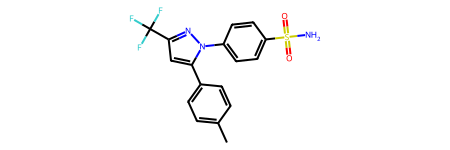

In [10]:
Chem.MolFromSmiles(cox2db[ cox2db['Molecule ChEMBL ID'] == 'CHEMBL118']['Smiles'].unique()[0])

## Example: Celecoxib (CHEMBL118)

It is likely that the repetitions mean different assays. Especially, some common known COX-2 inhibitors are used in many assays as reference. For example, Celecoxib ([CHEMBL118](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL118/)) appears in 287 different assays of 10 different types:

In [11]:
len(cox2db[ cox2db['Molecule ChEMBL ID'] == 'CHEMBL118']['Assay ChEMBL ID'].unique())

287

In [12]:
cox2db[ cox2db['Molecule ChEMBL ID'] == 'CHEMBL118']['Standard Type'].value_counts()

Standard Type
IC50          209
Inhibition     66
Activity        8
Ki              2
Delta G         1
Ka              1
FC              1
INH             1
AC50            1
T1/2            1
Name: count, dtype: int64

### $IC_{50}s$

Most values (209) are for IC50, which is notoriously imprecise. Note the variation in values:

In [13]:
cox2db[ (cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') & (cox2db['Standard Type'] == 'IC50')]["Standard Value"].describe()

count       209.000000
mean       4257.572967
std       40029.361475
min           0.520000
25%          40.000000
50%         100.000000
75%         440.000000
max      430000.000000
Name: Standard Value, dtype: float64

First, let's check how many different units are used:

In [16]:
cox2db[ (cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') & (cox2db['Standard Type'] == 'IC50')]["Standard Units"].unique()

array(['nM'], dtype=object)

Good... At least it seems to have only one unit reported. So, let's take a look into the results:

[Text(0.5, 0, 'IC50 Value')]

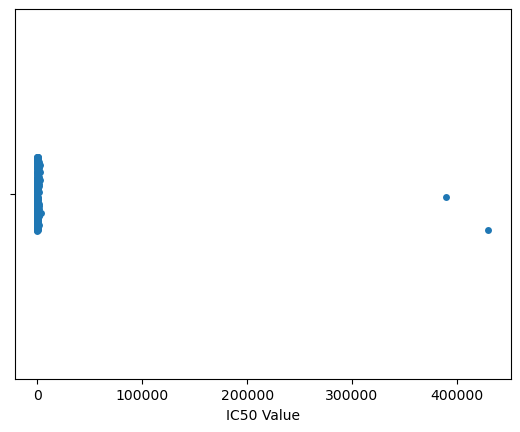

In [27]:
g = sns.stripplot(data = cox2db[ (cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') &
                                 (cox2db['Standard Type'] == 'IC50')
                               ], 
                   x = "Standard Value")
g.set(xlabel='IC50 Value')

Ugh!!

The most likely reason for the very high values are wrong reported units or typos. ChEMBL provides a column with comments about data validity:

In [28]:
cox2db['Data Validity Comment'].unique()

array([nan, 'Outside typical range', 'Potential transcription error',
       'Potential missing data'], dtype=object)

Let's see which comments are in the database:

In [29]:
cox2db['Data Validity Comment'].value_counts()

Data Validity Comment
Outside typical range            409
Potential transcription error      9
Potential missing data             1
Name: count, dtype: int64

The `Data Validity Comment` column only has any contents when there is some indication that the data may be wrong. So, we can use this column to filter out obviuos outliers and dubious data. Does it get better?

[Text(0.5, 0, 'IC50 Value')]

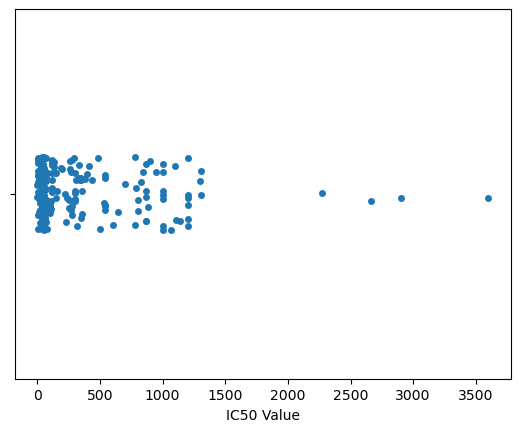

In [33]:
g = sns.stripplot(data = cox2db[ (cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') &
                                 (cox2db['Standard Type'] == 'IC50') &
                                 (cox2db['Data Validity Comment'].isna())
                               ], 
                   x = "Standard Value")
g.set(xlabel='IC50 Value')

A bit better... But there's still some values that are way too high. If we remove the aberrant values above 1,000, we get:

[Text(0.5, 23.52222222222222, 'IC50 Value')]

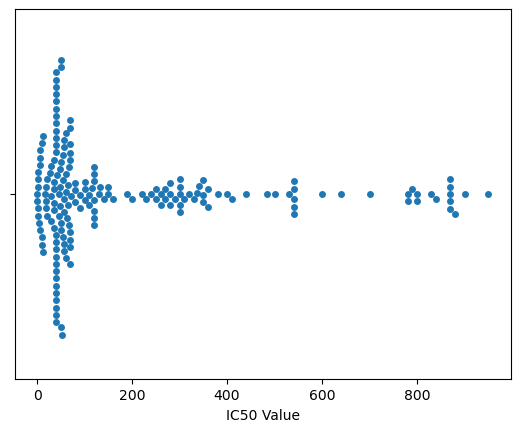

In [35]:
g = sns.swarmplot(data = cox2db[ (cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') &
                                 (cox2db['Standard Type'] == 'IC50') &
                                 (cox2db['Data Validity Comment'].isna()) &
                                 (cox2db['Standard Value'] < 1000)
                               ], 
                   x = "Standard Value")
g.set(xlabel='IC50 Value')

So, what is the $IC_{50}$ for Celecoxib, after all?

As an aside, instead of the $IC_{50}s$, we can use the $-Log(IC_{50})$ value, which has less variation. Let's look at it's distribution:

<Axes: xlabel='pChEMBL Value'>

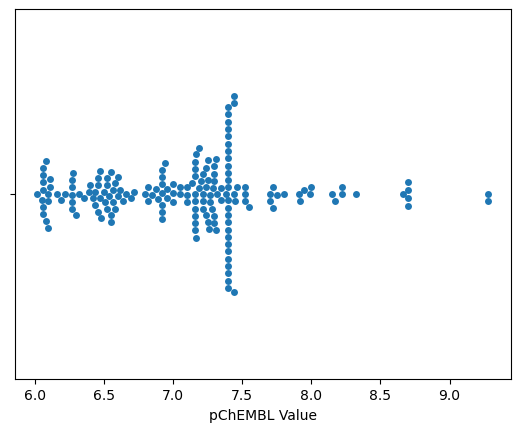

In [43]:
sns.swarmplot(data=cox2db[(cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') &
                          (cox2db['Standard Type'] == 'IC50') &
                          (cox2db['Standard Relation'] == "'='") &
                          (cox2db['Data Validity Comment'].isna()) &
                          (cox2db['Standard Value'] < 1000)
                        ],
             x='pChEMBL Value')

### Inhibition

66 of the experiments report "Inhibition": 

<Axes: xlabel='Standard Value', ylabel='Count'>

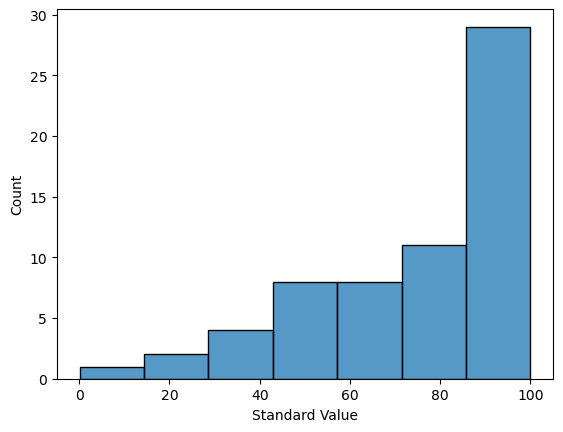

In [44]:
# Inhibition
data = cox2db[ (cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') &
               (cox2db['Standard Type'] == 'Inhibition')     &
               (cox2db['Standard Units'] == '%')]

sns.histplot(data = data, x='Standard Value')

In [45]:
data["Standard Value"].describe()

count     63.000000
mean      76.037873
std       24.602662
min        0.076000
25%       60.500000
50%       83.000000
75%       96.200000
max      100.000000
Name: Standard Value, dtype: float64

### Activity

8 entries are just labeled "Activity", but the information seems meaningless. They are probably relative to some other compound, not shown here. That means those numbers cannot be used!

<Axes: ylabel='Standard Value'>

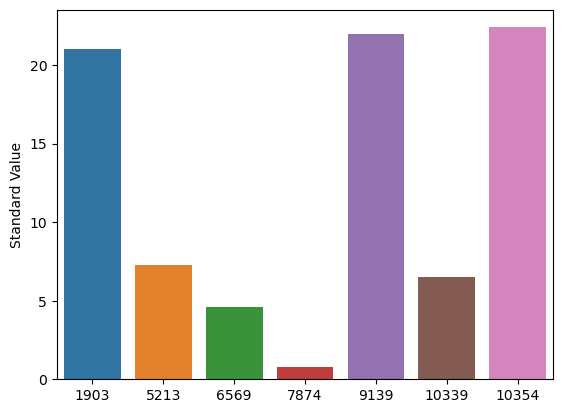

In [27]:
data = cox2db[ (cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') & (cox2db['Standard Type'] == 'Activity')]
sns.barplot(data=data, x=data.index, y='Standard Value')

### $\Delta G$, $K_a$ and $K_i$

Those are usually the most precise types of data, but are harder to get. There's only 4 values in the data, and it turns out the numbers in the database are not very informative:

In [48]:
data = cox2db[ (cox2db['Molecule ChEMBL ID'] == 'CHEMBL118') &
                 ((cox2db['Standard Type'] == 'Delta G') | 
                  (cox2db['Standard Type'] == 'Ka')      |
                  (cox2db['Standard Type'] == 'Ki')
                 )]
data

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
3856,CHEMBL118,CELECOXIB,4.0,381.38,0.0,3.51,1,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,Delta G,'=',0.00,kCal mol-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,CHEMBL768430,Relative free energy of binding of compound to...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1134800,1,Scientific Literature,Bioorg Med Chem Lett,2001.0,NaN,NaN,NaN,NaN
8232,CHEMBL118,CELECOXIB,4.0,381.38,0.0,3.51,CELECOXIB,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,Ka,'=',2.15,10'4/M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,CHEMBL3380382,Binding affinity to COX-2 (unknown origin) by ...,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL3351295,1,Scientific Literature,Eur J Med Chem,2014.0,NaN,NaN,NaN,NaN
8265,CHEMBL118,CELECOXIB,4.0,381.38,0.0,3.51,CELECOXIB,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,Ki,NaN,NaN,NaN,NaN,NaN,Note: corresponding IC50 reported as Active,NaN,NaN,NaN,NaN,NaN,0,CHEMBL1909131,DRUGMATRIX: Cyclooxygenase COX-2 enzyme inhibi...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,Sf21,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL4106362,NaN,NaN,NaN
9734,CHEMBL118,CELECOXIB,4.0,381.38,0.0,3.51,Celecoxib,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,Ki,'=',0.47,nM,9.33,NaN,NaN,UO_0000065,24.46,0.49,5.82,11.96,0,CHEMBL4810382,Inhibition of human recombinant COX-2 using ar...,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL4808216,1,Scientific Literature,J Med Chem,2021.0,NaN,TIME = 1.0 hr,INHIBITOR,NaN


This $K_a$ can be converted to a $\Delta G$ by 

$\Delta G = -R T Ln(K_a)$. 

Using:
- $R = 1.987 \times 10^{-3} kcal \cdot K^{−1} \cdot mol−1$
- $T = 298 K$

we get $\Delta G = -5.91 kcal/mol$ .

## Exploring the Data Types in the Full Database

In [49]:
data = cox2db['Standard Type'].value_counts()
data

Standard Type
IC50                                         7891
Inhibition                                   3315
AC50                                         1193
Ki                                            899
Activity                                      398
Ratio IC50                                    110
-log(RatioIC50)                                42
NT                                             20
Ka                                             18
% Ctrl                                         15
Enzyme inhibition                              12
Imax                                           12
Kd                                              8
% Inhibition of Control Values (Mean n=2)       8
T1/2                                            8
FC                                              5
ED50                                            4
K                                               4
Drug metabolism                                 4
Delta G                             

/scratch/local/42638932/ipykernel_3378453/1226048823.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g = g.set_xticklabels(g.get_xticklabels(),rotation=90)


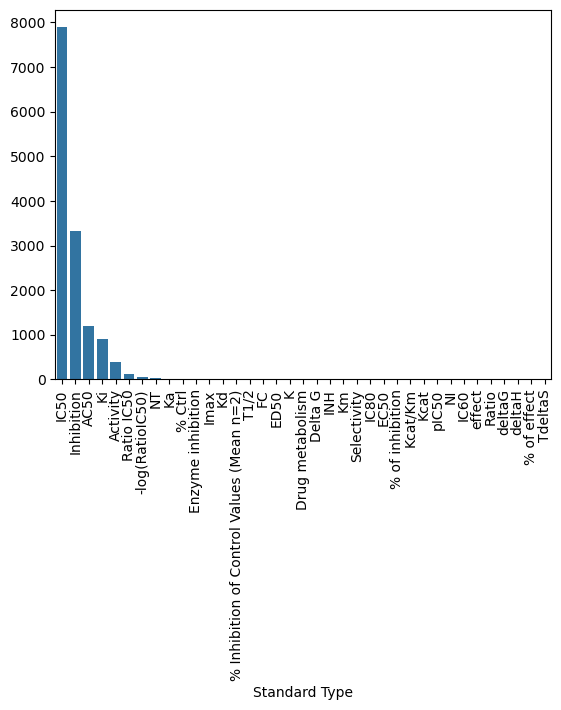

In [50]:
g = sns.barplot(x=data.index, y=data.values)
g = g.set_xticklabels(g.get_xticklabels(),rotation=90)

So, most of the data is in the form of IC50s. Some molecules also have inhibition, Ki and activity. Let's take a look at the different kinds of data. 

### $IC_{50}s$

We got lucky with Celecoxib. When we look at the full data, the IC50 data is reported in many different units:

In [72]:
data = cox2db[cox2db['Standard Type'] == 'IC50']
data['Standard Units'].value_counts()

Standard Units
nM         6882
ug.mL-1      25
%             1
ug            1
Name: count, dtype: int64

We can probably discard all that are not in nM units. Still, even if we only consider the data in 'nM', apparently there's data without values, either in 'Standard Value' or 'pChEMBL value':

In [73]:
data = data[ data['Standard Units'] == 'nM' ]
data['Standard Value'].isna().any(), data['pChEMBL Value'].isna().any()

(np.True_, np.True_)

The maximum and minimum values are also weird an IC50 of 0 nM makes no sense:

In [56]:
data['Standard Value'].max(), data['Standard Value'].min()

(np.float64(833335724.28), np.float64(0.0))

In [57]:
data['Standard Value'].describe()

count    8.097000e+03
mean     9.035404e+05
std      1.817640e+07
min      0.000000e+00
25%      1.600000e+02
50%      2.050000e+03
75%      3.000000e+04
max      8.333357e+08
Name: Standard Value, dtype: float64

### Inhibition

In [58]:
data = cox2db[ cox2db['Standard Type'] == 'Inhibition' ]

Some inhibitions are in $\mu M$ units, which doesn't make much sense. Let's remove those. 

In [59]:
data['Standard Units'].value_counts()

Standard Units
%     3290
uM      25
Name: count, dtype: int64

In [60]:
data = data[ data['Standard Units'] == '%' ]

Some of the values are empty:

In [61]:
data['Standard Value'].isna().any()

np.True_

In [63]:
data['Standard Value'].describe()

count    2903.000000
mean       43.445277
std        34.260686
min      -125.000000
25%        15.900000
50%        39.000000
75%        72.395000
max       158.200000
Name: Standard Value, dtype: float64

<Axes: >

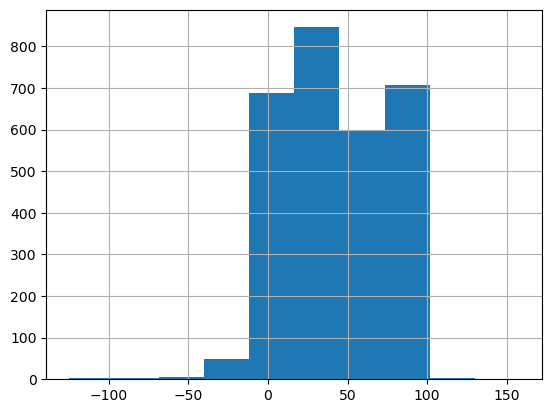

In [64]:
data['Standard Value'].hist()

What does it mean to have **negative** % inhibition????

In [66]:
data[data['Standard Value'] < 0].head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
33,CHEMBL18007,NaN,NaN,355.39,0.0,4.30,7,O=C1/C(=C(/O)c2ccccc2)c2ccccc2C(=O)N1Cc1ccccc1,Inhibition,'=',-3.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,0,CHEMBL763345,Inhibitory activity against Prostaglandin G/H ...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1130988,1,Scientific Literature,Bioorg Med Chem Lett,1998.0,NaN,NaN,NaN,NaN
180,CHEMBL306894,NaN,NaN,365.41,0.0,2.78,6a,CS(=O)(=O)c1ccc(-c2cc(CO[N+](=O)[O-])nn2C2CCCC...,Inhibition,'=',-125.0,%,NaN,Outside typical range,NaN,UO_0000187,NaN,NaN,NaN,NaN,0,CHEMBL761116,Evaluation for percent inhibition of recombina...,B,BAO_0000221,tissue-based format,NaN,CHEMBL3638178,Blood,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1149153,1,Scientific Literature,J Med Chem,2004.0,NaN,NaN,NaN,NaN
501,CHEMBL177083,NaN,NaN,394.84,0.0,2.85,25,COc1ccc2c(c1)C(O)=C(C(=O)Nc1ccc(Cl)cc1)N(C)S2(...,Inhibition,'=',-9.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,0,CHEMBL763160,Inhibition of human Prostaglandin G/H synthase...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1129978,1,Scientific Literature,J Med Chem,1997.0,NaN,NaN,NaN,NaN
642,CHEMBL367970,NaN,NaN,417.87,0.0,3.33,68,CN1C(C(=O)Nc2ccccc2)=C(O)c2c(c3cc(Cl)ccc3n2C)S...,Inhibition,'=',-3.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,0,CHEMBL763159,Inhibition of human Prostaglandin G/H synthase...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1129978,1,Scientific Literature,J Med Chem,1997.0,NaN,NaN,NaN,NaN
672,CHEMBL4872569,NaN,NaN,315.35,0.0,2.43,5b,Cc1cc(-c2cccnc2)nn1S(=O)(=O)Oc1ccccc1,Inhibition,'=',-2.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,0,CHEMBL4810972,Inhibition of human recombinant COX-2 assessed...,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL4808246,1,Scientific Literature,Bioorg Med Chem,2021.0,NaN,Dose = 0.1 microM | TIME = 1.033 hr,NaN,NaN


A look at the source for the second entry reveals that this compound can actually be considered an activator of COX-2!!
 - ChEMBL Document [CHEMBL1149153](https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL1149153/)
 - J. Med. Chem. 2004, 47, 9, 2180–2193 [here](https://pubs.acs.org/doi/10.1021/jm030276s)
 
 
That means that, to use inhibitions, we should also remove data vith inhibition < 0. 

### $AC_{50}s$

The third in the list is the concentration for half-maximal activity, $AC_{50}$:

In [74]:
data = cox2db[cox2db['Standard Type'] == 'AC50']
data['Standard Units'].value_counts()

Standard Units
nM    1193
Name: count, dtype: int64

So, they are all in the same units, which is good. However, some are missing the 'pChEMBL value':

In [76]:
data['Standard Value'].isna().any(), data['pChEMBL Value'].isna().any()

(np.False_, np.True_)

There's also a weird variation in values:

In [78]:
data['Standard Value'].max(), data['Standard Value'].min()

(np.float64(1000000.0), np.float64(48.4))

In [79]:
data['Standard Value'].describe()

count       1193.000000
mean       27801.344091
std        41885.943446
min           48.400000
25%        10000.000000
50%        30000.000000
75%        30000.000000
max      1000000.000000
Name: Standard Value, dtype: float64

<Axes: xlabel='Standard Value', ylabel='Count'>

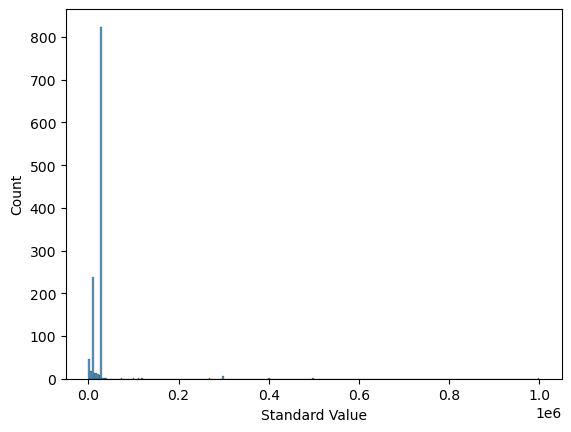

In [84]:
sns.histplot(data = data, x='Standard Value')

Again, Ugh! The very large values are likely "inactive" molecules, where the data is reported just as _greater than_ some detection limit $X$ 

In [85]:
data["Standard Relation"].value_counts()

Standard Relation
'>'    1052
'='     141
Name: count, dtype: int64

So, only about 141 points with real numbers.

### $K_i$

Next, lets look at $K_i$, with 899 entries.

In [86]:
data = cox2db[ cox2db['Standard Type'] == 'Ki' ]

From those, most have no value reported, because the dose-response curve could not be determined:

In [87]:
data['Standard Value'].isna().sum()

np.int64(871)

In [88]:
data.head(1)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL1200623,ETHYLESTRENOL,4.0,288.48,1.0,5.09,ETHYLESTRENOL,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,0,CHEMBL1909131,DRUGMATRIX: Cyclooxygenase COX-2 enzyme inhibi...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,Sf21,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL4106362,NaN,NaN,NaN


In [89]:
print(data.loc[0]['Comment'])

Not Active (inhibition < 50% @ 10 uM and thus dose-reponse curve not measured)


Ant those that have a value reported include a range of different data. Some of the data are only " > " a certain threshold, indicating not active. 

In [90]:
data[data['Standard Value'].notna()]['Standard Relation'].value_counts()

Standard Relation
'='    26
'>'     2
Name: count, dtype: int64

Also, some have $K_i = 0$:

### Activity
Activity, which is listed for 398 cases:

In [92]:
data = cox2db[ cox2db['Standard Type'] == 'Activity' ]

In [93]:
data['Standard Units'].value_counts()

Standard Units
%        226
pg/ml     23
ng/ml     17
Name: count, dtype: int64

In [94]:
data[ data['Standard Units'] == 'ng/ml' ].head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
1901,CHEMBL3809156,NaN,NaN,406.48,0.0,-0.51,30,COC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1ccccc1)NC(=...,Activity,'=',0.08,ng/ml,NaN,NaN,NaN,UO_0000275,NaN,NaN,NaN,NaN,0,CHEMBL3811634,Inhibition of COX2 in healthy human whole bloo...,B,BAO_0000221,tissue-based format,Homo sapiens,CHEMBL3638178,Blood,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL3808358,1,Scientific Literature,J Med Chem,2016.0,NaN,NaN,NaN,NaN
2608,CHEMBL6,INDOMETHACIN,4.0,357.79,0.0,3.93,indomethacin,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,Activity,'=',2.10,ng/ml,NaN,NaN,NaN,UO_0000275,NaN,NaN,NaN,NaN,0,CHEMBL3811634,Inhibition of COX2 in healthy human whole bloo...,B,BAO_0000221,tissue-based format,Homo sapiens,CHEMBL3638178,Blood,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL3808358,1,Scientific Literature,J Med Chem,2016.0,NaN,NaN,NaN,NaN
3784,CHEMBL4640256,NaN,NaN,414.90,0.0,2.50,10,COC(=O)[C@@H](N)Cc1cn(-c2nc(Cl)nc(N3CCCCC3)n2)...,Activity,'=',0.45,ng/ml,NaN,NaN,NaN,UO_0000275,NaN,NaN,NaN,NaN,0,CHEMBL4610813,Inhibition of LPS-activated COX2 in human whol...,B,BAO_0000221,tissue-based format,Homo sapiens,CHEMBL3638178,Blood,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL4610009,1,Scientific Literature,Bioorg Med Chem,2020.0,NaN,NaN,NaN,NaN
3785,CHEMBL6,INDOMETHACIN,4.0,357.79,0.0,3.93,Indomethacin,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,Activity,'=',0.98,ng/ml,NaN,NaN,NaN,UO_0000275,NaN,NaN,NaN,NaN,0,CHEMBL4610813,Inhibition of LPS-activated COX2 in human whol...,B,BAO_0000221,tissue-based format,Homo sapiens,CHEMBL3638178,Blood,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL4610009,1,Scientific Literature,Bioorg Med Chem,2020.0,NaN,NaN,NaN,NaN
4287,CHEMBL4164251,NaN,NaN,320.74,0.0,1.21,2,Nc1nc(Cl)nc(Nc2ccc(N3CCOCC3=O)cc2)n1,Activity,'=',1.14,ng/ml,NaN,NaN,NaN,UO_0000275,NaN,NaN,NaN,NaN,0,CHEMBL4151940,Inhibition of COX2 in human whole blood assess...,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL230,Cyclooxygenase-2,Homo sapiens,SINGLE PROTEIN,CHEMBL4145689,1,Scientific Literature,J Med Chem,2018.0,NaN,NaN,NaN,NaN


This is a relly hard data to analyze. Looking at one document [here](https://pubs.acs.org/doi/10.1021/acs.jmedchem.8b00922), we see that the data listed as "inhibition" actually is the . _"Inhibition of TxB2 during Calcium-Ionophore Stimulation and Inhibition of PGE2 during LPS-Stimulation of Human Whole Blood"_, at the compound concentration of 1 μM.

The only way to use this data is by looking at each article case-by-case! However, the same papers can also have IC50s for the molecules, so we can use that instead.

# Build Database

There are a total of 8,545 compounds wth unique SMILES in the database. However, the database actually has:

- 7891 entries for $IC_{50}$ (which seems to be the most complete type of data). 
- 3315 entries with "Inhibition" data
- 1193 with "$AC_{50}$s"
- 899 with $K_i$ data, from which only 25 acctually have any data to it.
- 398 with "Activity" data.

It is likely that we can get *some* data on all molecules by using a combination of these.

## IC50s <font color='red'> STOPPED HERE </font>

We will only use the following columns:

In [52]:
cox2db.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

Let's do some checking first. We start with 7,058 entries with IC50 data:


In [53]:
data = cox2db[ (cox2db['Standard Type']     == 'IC50') ]
len(data)

7383

From those, 999 don't ave any value annotated:

In [54]:
data['Standard Value'].isna().sum()

999

Also, some of them don't have SMILES strings:

In [55]:
data['Smiles'].isna().sum()

33

Furthermore, some even have the data annotated only as _"larger than"_ or _"smaller than"_ some value:

In [56]:
data[data['Standard Value'].notna()]['Standard Relation'].value_counts()

Standard Relation
'='     5388
'>'      938
'<'       56
'>='       1
Name: count, dtype: int64

Others are reported in different units:

In [57]:
data['Standard Units'].value_counts()

Standard Units
nM         6380
ug.mL-1      20
%             1
ug            1
µM            1
Name: count, dtype: int64

Finally, some have _"comments"_ that indicate the data may be problematic:

In [58]:
data['Data Validity Comment'].value_counts()

Data Validity Comment
Outside typical range            297
Potential transcription error      9
Non standard unit for type         3
Name: count, dtype: int64

In [59]:
del(data)

**We will need to remove all those cases**

Lets start only with data for which we have:

1. Measured IC50 values
1. The value is "equal" to some number (We can look for other relations later)
1. There is a Smiles value
1. Have no warnings on data value

In [60]:
columns = ['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
           'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value','Standard Units']

In [61]:
ic50_data = cox2db[ (cox2db['Standard Type']     == 'IC50')  &
                    (cox2db['Standard Relation'] ==  "'='")  &
                    (cox2db['Standard Units']    ==  'nM' )  &
                    (cox2db['Smiles'].notna()             )  &
                    (cox2db['Data Validity Comment'].isna()) ][columns]

print("Total number of entries that match the criteria:", len(ic50_data))
print("Number of entries with unique SMILES strings:   ", len(ic50_data['Smiles'].unique()))
print("Do the number of unique SMILES match the number of unique ChEMBL IDs?", 
      len(ic50_data['Smiles'].unique()) == len(ic50_data['Molecule ChEMBL ID'].unique()))

Total number of entries that match the criteria: 5108
Number of entries with unique SMILES strings:    3616
Do the number of unique SMILES match the number of unique ChEMBL IDs? True


In [62]:
ic50_data.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase', 'Smiles',
       'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units'],
      dtype='object')

**Wisdom of the crowd**

There are a total of 4,857 entries that match the criteria, but only 3,423 unique molecules. That means there is a lot of duplicate data. So, for each molecule, we will choose the **most common** value (`mode`).

In [63]:
# This creates a new DataFrame to hold unique entries, and use the `mode` od IC50s for that molecule as the value.
cox2_ic50s = pd.DataFrame(columns=columns)
for  ic50_data_line in tqdm(ic50_data['Molecule ChEMBL ID'].unique()):
    new_row =  ic50_data[ ic50_data['Molecule ChEMBL ID'] ==  ic50_data_line].mode().head(1).copy(deep=True)
    #cox2_ic50s = cox2_ic50s.append(new_row, ignore_index=True)
    cox2_ic50s = pd.concat([cox2_ic50s,new_row])
cox2_ic50s.shape

100%|██████████| 3616/3616 [00:12<00:00, 278.34it/s]


(3616, 8)

In [64]:
cox2_ic50s.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
0,CHEMBL2115305,NaN,0,COc1ccc2c(c1)c(CC(=O)NN1CCC[C@@H]1CO)c(C)n2C(=...,IC50,'=',1700.00,nM
0,CHEMBL274841,NaN,0,Cc1ccc(-c2ncc(Cl)cc2-c2ccc(S(C)(=O)=O)cc2)c[n+...,IC50,'=',18000.00,nM
0,CHEMBL15791,NaN,0,CONC1=NC(=O)/C(=C/c2cc(C(C)(C)C)c(O)c(C(C)(C)C...,IC50,'=',1700.00,nM
0,CHEMBL72294,NaN,0.0,Cc1ccc(-n2c(-c3ccc(S(N)(=O)=O)cc3)c(C)oc2=O)cc1,IC50,'=',1698.24,nM
0,CHEMBL304054,NaN,0.0,Cc1cccc(-n2c(-c3ccc(S(N)(=O)=O)cc3)coc2=O)c1,IC50,'=',510.00,nM


In [65]:
cox2_ic50s.shape

(3616, 8)

In [66]:
len( cox2_ic50s['Smiles'].unique() )

3616

In [67]:
len( cox2_ic50s['Molecule ChEMBL ID'].unique() )

3616

In [68]:
len(cox2_ic50s)

3616

In [69]:
cox2_ic50s.describe()

,Standard Value
count,3616.000000
mean,6938.759048
std,15924.115916
min,0.020000
25%,100.000000
50%,774.915000
75%,5200.000000
max,100000.000000


OK, now we have 3,616 unique molecules with IC50 measured in nM units. we don't need the 'ic50_data' DataFrame ay longer, let's delete it.

In [70]:
del(ic50_data, ic50_data_line)

**Summary**

From an initial total of 12,155 entries, there were only 7,342 unique molecules. From those, only  3,616 were unique molecules with reasonably useful IC50 data.

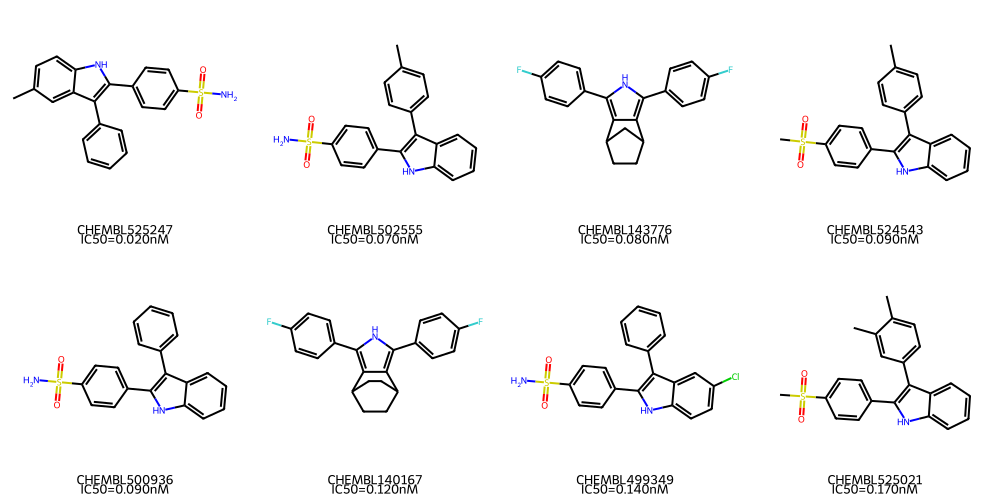

In [71]:
# A quick look at the molecules
n_to_draw = 8
df = cox2_ic50s.sort_values(by=["Standard Value"],ascending=[True]).head(n_to_draw)
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='Smiles')
mols = df.ROMol.values
top_ic50s = df['Molecule ChEMBL ID'].values
legends = []
for chemblid, ic50, unit in zip(df['Molecule ChEMBL ID'].values, df['Standard Value'].values, df['Standard Units']):
    legends.append(f"{chemblid}\nIC50={ic50:.3f}{unit}") 
Draw.MolsToGridImage(mols, molsPerRow=4,subImgSize=(250,250), legends=legends)

## Pre-process database

Now we need to pre-process the database, to:

1. Remove molecules that contain atoms other than ['C','N','O','H','S','P','As','Se','F','Cl','Br','I']
1. Standardize (remove salts, etc.)
1. Reset the SMILES from the ROMol objects
1. Remove duplicates

In [72]:
clean_df, dup_df = preprocess.preprocess_db(cox2_ic50s, smiles_col='Smiles')

Removing molecules with invalid atoms:   0%|          | 0/3616 [00:00<?, ?it/s]

Standardizing:   0%|          | 0/3590 [00:00<?, ?it/s]

Resetting SMILES:   0%|          | 0/3590 [00:00<?, ?it/s]

Generating InChI Keys:   0%|          | 0/3590 [00:00<?, ?it/s]

In [73]:
cox2_ic50s.shape, clean_df.shape, dup_df.shape

((3616, 10), (3590, 10), (0, 0))

In [74]:
clean_df.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'ROMol', 'Smiles', 'InChI Key'],
      dtype='object')

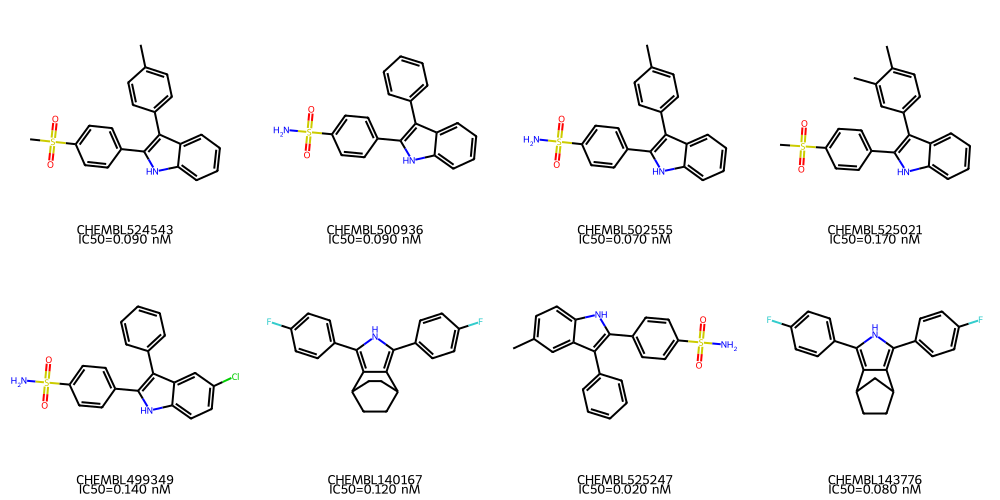

In [75]:
# A quick look at the molecules
n_to_draw = 8
df = clean_df[ clean_df['Molecule ChEMBL ID'].isin(top_ic50s) ]
mols = df.ROMol.values
legends = []
for chemblid, ic50, unit in zip(df['Molecule ChEMBL ID'].values, df['Standard Value'].values, df['Standard Units'].values):
    legends.append(f"{chemblid}\nIC50={ic50:.3f} {unit}") 
Draw.MolsToGridImage(mols, molsPerRow=4,subImgSize=(250,250), legends=legends)

In [76]:
clean_df['Standard Units'].unique()

array(['nM'], dtype=object)

So, the there were 52 molecules with atoms other than ['C','N','O','H','S','P','As','Se','F','Cl','Br','I']. Other than that, all was fine.

In [77]:
cox2_ic50s = clean_df.copy(deep=True)

We no longer need these other databases, let's remove them.

In [78]:
del(clean_df,dup_df)

In [79]:
cox2_ic50s.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Standard Type,Standard Relation,Standard Value,Standard Units,ROMol,Smiles,InChI Key
0,CHEMBL2115305,NaN,0,IC50,'=',1700.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b838fe4a0>,COc1ccc2c(c1)c(CC(=O)NN1CCC[C@@H]1CO)c(C)n2C(=...,IBWROCWYMVFROI-ZYTCOXICNA-N
1,CHEMBL274841,NaN,0,IC50,'=',18000.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b838fe740>,Cc1ccc(-c2ncc(Cl)cc2-c2ccc(S(C)(=O)=O)cc2)c[n+...,KMLFAHIIJSUUPX-UHFFFAOYNA-N
2,CHEMBL15791,NaN,0,IC50,'=',1700.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b8390dcf0>,CONC1=NC(=O)/C(=C/c2cc(C(C)(C)C)c(O)c(C(C)(C)C...,ZJFXWSPUWDWLPL-ORKNZVJUNA-N
3,CHEMBL72294,NaN,0.0,IC50,'=',1698.24,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b83911270>,Cc1ccc(-n2c(-c3ccc(S(N)(=O)=O)cc3)c(C)oc2=O)cc1,JAPKJIUHTVTGNM-DZQCGVKKNA-N
4,CHEMBL304054,NaN,0.0,IC50,'=',510.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b83911350>,Cc1cccc(-n2c(-c3ccc(S(N)(=O)=O)cc3)coc2=O)c1,VDJKUOJXTDRTKV-HVXXBKQBNA-N


Finally, let's convert the IC50 values to log-scale:

In [80]:
cox2_ic50s['pIC50'] = np.log10(cox2_ic50s['Standard Value'].astype(float))

In [81]:
cox2_ic50s.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Standard Type,Standard Relation,Standard Value,Standard Units,ROMol,Smiles,InChI Key,pIC50
0,CHEMBL2115305,NaN,0,IC50,'=',1700.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b838fe4a0>,COc1ccc2c(c1)c(CC(=O)NN1CCC[C@@H]1CO)c(C)n2C(=...,IBWROCWYMVFROI-ZYTCOXICNA-N,3.230449
1,CHEMBL274841,NaN,0,IC50,'=',18000.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b838fe740>,Cc1ccc(-c2ncc(Cl)cc2-c2ccc(S(C)(=O)=O)cc2)c[n+...,KMLFAHIIJSUUPX-UHFFFAOYNA-N,4.255273
2,CHEMBL15791,NaN,0,IC50,'=',1700.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b8390dcf0>,CONC1=NC(=O)/C(=C/c2cc(C(C)(C)C)c(O)c(C(C)(C)C...,ZJFXWSPUWDWLPL-ORKNZVJUNA-N,3.230449
3,CHEMBL72294,NaN,0.0,IC50,'=',1698.24,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b83911270>,Cc1ccc(-n2c(-c3ccc(S(N)(=O)=O)cc3)c(C)oc2=O)cc1,JAPKJIUHTVTGNM-DZQCGVKKNA-N,3.229999
4,CHEMBL304054,NaN,0.0,IC50,'=',510.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b83911350>,Cc1cccc(-n2c(-c3ccc(S(N)(=O)=O)cc3)coc2=O)c1,VDJKUOJXTDRTKV-HVXXBKQBNA-N,2.707570


<Axes: >

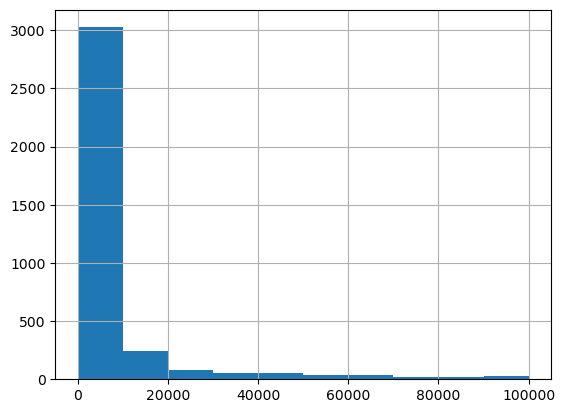

In [82]:
cox2_ic50s['Standard Value'].hist()

<Axes: >

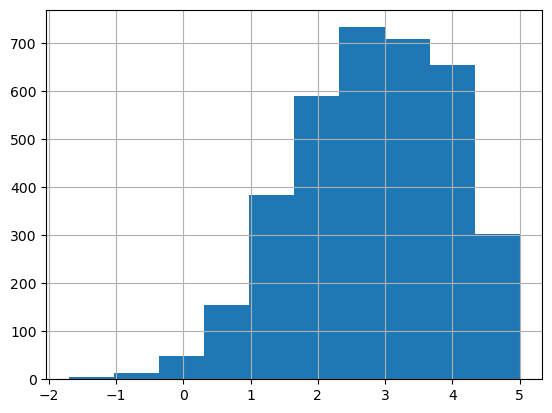

In [83]:
cox2_ic50s['pIC50'].hist()

In [84]:
len(cox2_ic50s)

3590

In [85]:
cox2_ic50s.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'ROMol', 'Smiles', 'InChI Key', 'pIC50'],
      dtype='object')

In [86]:
#cox2_ic50s[['Smiles','Molecule ChEMBL ID','Standard Value']].to_csv('cox2_ic50s.smi', sep=' ' , index=False)

In [87]:
#cox2_ic50s[['Smiles','Molecule ChEMBL ID', 'pIC50']].to_csv('cox2_pIC50s.smi', sep=' ' ,index=False)

In [88]:
len(cox2_ic50s['Molecule ChEMBL ID'].unique())

3590

# Exploring the Database

## Add Elion Properties
Note that to add CHEMBERT_BEs, this must be done AFTER the preparation of the CHEMBERT modelm

In [89]:
!pwd

/home/seabra/work/li/elion_dev/tests/modular/hCOX2/chembl31


In [90]:
elion_input = input_reader.read_input_file('elion_input.yml')

Input File
reward_function:
     ADMET_Risk:
          RunAP_executable: /opt/SimulationsPlus/bin/RunAP.sh
          calculate: 'True'
     CHEMBERT_BE:
          calculate: 'True'
          model_file: /home/seabra/work/li/elion_dev/tests/modular/hCOX2/qsar_model/chembl31/CHEM-BERT_ft/glide_scores/chembert/Finetuned_model_15.pt
     Intestinal_Absorption:
          RunAP_executable: /opt/SimulationsPlus/bin/RunAP.sh
          calculate: 'True'
     Oral_Bioavailability:
          RunAP_executable: /opt/SimulationsPlus/bin/RunAP.sh
          calculate: 'True'
     QED_Score:
          calculate: 'True'
     SAScore:
          calculate: 'True'
     Similarity_Score:
          calculate: 'True'
          reference_smi: Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1
          region_selector: generic_molecule



In [91]:
estimator = Estimators(elion_input['Reward_function'])

--------------------------------------------------------------------------------
Loading Property: SIMILARITY_SCORE
When using this property, please cite:
  "RDKit: Open-source cheminformatics version 2023.03.2 (www.rdkit.org)"

  Reward Weight = 1.0
  Reward class = hard
  Initial Threshold = 0.0
  Optimize:  False
Using molecule 'Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1' as refence for similarity. 
Using the Generic molecule for similarity measures. 
(All atoms are carbons and all bonds are single bonds)
Done Loading Property: SIMILARITY_SCORE
--------------------------------------------------------------------------------
Loading Property: SASCORE
When using this property, please cite:
  "RDKit: Open-source cheminformatics version 2023.03.2 (www.rdkit.org)"

  Reward Weight = 1.0
  Reward class = hard
  Initial Threshold = 0.0
  Optimize:  False
Initialized fragment scores.
Done Loading Property: SASCORE
---------------------------------------------------------------------

In [92]:
cox2_ic50s.drop(columns='ROMol')
PandasTools.AddMoleculeColumnToFrame(cox2_ic50s, smilesCol='Smiles')
elion_predictions = estimator.estimate_properties(cox2_ic50s.ROMol.values)

In [93]:
# Sanity chack
len(cox2_ic50s), [len(elion_predictions[x]) for x in elion_predictions.keys()]

(3590, [3590, 3590, 3590, 3590, 3590, 3590, 3590])

In [94]:
for key in elion_predictions.keys():
    print(key)
    cox2_ic50s[key] = elion_predictions[key]

Similarity_Score
SAScore
QED_Score
CHEMBERT_BE
ADMET_Risk
Oral_Bioavailability
Intestinal_Absorption


In [95]:
cox2_ic50s.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Standard Type,Standard Relation,Standard Value,Standard Units,ROMol,Smiles,InChI Key,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
0,CHEMBL2115305,NaN,0,IC50,'=',1700.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b83977c10>,COc1ccc2c(c1)c(CC(=O)NN1CCC[C@@H]1CO)c(C)n2C(=...,IBWROCWYMVFROI-ZYTCOXICNA-N,3.230449,0.842105,3.067362,0.595304,-6.480067,1.115664,92.41,98.93
1,CHEMBL274841,NaN,0,IC50,'=',18000.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b83977eb0>,Cc1ccc(-c2ncc(Cl)cc2-c2ccc(S(C)(=O)=O)cc2)c[n+...,KMLFAHIIJSUUPX-UHFFFAOYNA-N,4.255273,0.868421,2.610991,0.519766,-10.484391,0.000000,93.66,99.98
2,CHEMBL15791,NaN,0,IC50,'=',1700.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b84c65040>,CONC1=NC(=O)/C(=C/c2cc(C(C)(C)C)c(O)c(C(C)(C)C...,ZJFXWSPUWDWLPL-ORKNZVJUNA-N,3.230449,0.974359,2.934384,0.611906,-8.073941,2.905901,83.39,99.96
3,CHEMBL72294,NaN,0.0,IC50,'=',1698.24,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b84c650b0>,Cc1ccc(-n2c(-c3ccc(S(N)(=O)=O)cc3)c(C)oc2=O)cc1,JAPKJIUHTVTGNM-DZQCGVKKNA-N,3.229999,1.000000,2.274878,0.788786,-10.621233,0.000000,75.13,83.35
4,CHEMBL304054,NaN,0.0,IC50,'=',510.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b84c65120>,Cc1cccc(-n2c(-c3ccc(S(N)(=O)=O)cc3)coc2=O)c1,VDJKUOJXTDRTKV-HVXXBKQBNA-N,2.707570,1.000000,2.296152,0.794816,-10.500620,0.000000,87.84,97.07


In [96]:
len( cox2_ic50s[ cox2_ic50s['pIC50'] > 4.3 ] )

334

# Properties of Approved Molecules

In [97]:
approved = cox2_ic50s[ cox2_ic50s['Molecule Max Phase'] > 3 ]
approved.describe()

,Standard Value,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,8202.699806,2.585741,0.786799,2.238326,0.764256,-8.058934,1.965117,86.845000,95.323056
std,22013.465060,1.216342,0.101982,0.483251,0.140110,1.205382,1.626371,17.824033,13.037036
min,4.803000,0.681513,0.526316,1.295792,0.408716,-11.136306,0.000000,42.150000,46.720000
25%,36.750000,1.559386,0.710526,1.926052,0.728404,-8.722302,0.619782,92.145000,99.697500
50%,521.000000,2.716485,0.777473,2.147436,0.821600,-7.930749,1.704283,95.770000,99.960000
75%,2487.500000,3.394992,0.842105,2.465503,0.859567,-7.232438,2.959727,96.862500,99.990000
max,93300.000000,4.969882,1.000000,3.496406,0.905784,-6.079607,6.000000,97.860000,100.000000


In [98]:
approved.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'ROMol', 'Smiles', 'InChI Key', 'pIC50',
       'Similarity_Score', 'SAScore', 'QED_Score', 'CHEMBERT_BE', 'ADMET_Risk',
       'Oral_Bioavailability', 'Intestinal_Absorption'],
      dtype='object')

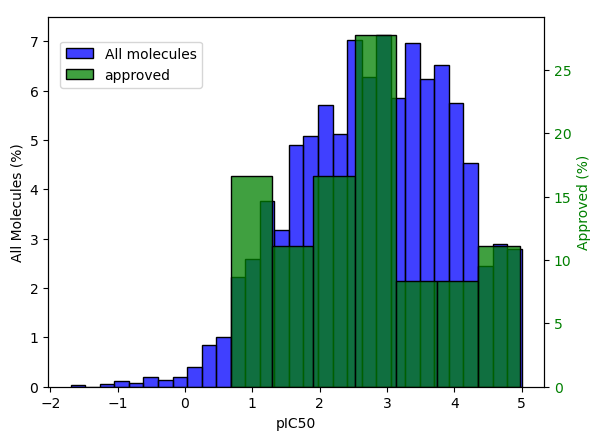

In [99]:
prop_to_plot = 'pIC50'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot,stat='percent', ax=ax2, color='green', label='approved')
sns.histplot(data=cox2_ic50s, x=prop_to_plot,stat='percent', ax=ax1, color='blue',   label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.1,0.8));

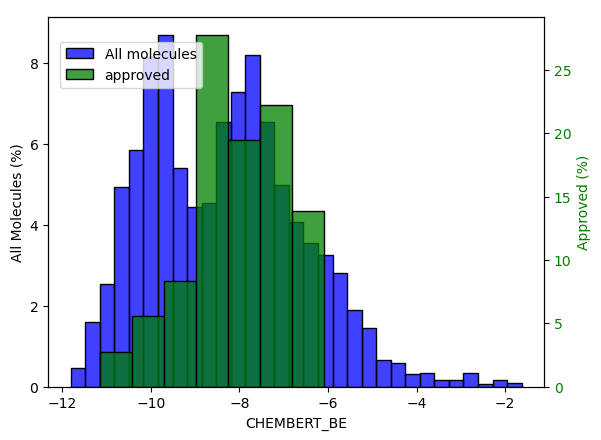

In [100]:
prop_to_plot = 'CHEMBERT_BE'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot,stat='percent', ax=ax2, color='green', label='approved')
sns.histplot(data=cox2_ic50s, x=prop_to_plot,stat='percent', ax=ax1, color='blue',   label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.1,0.8));

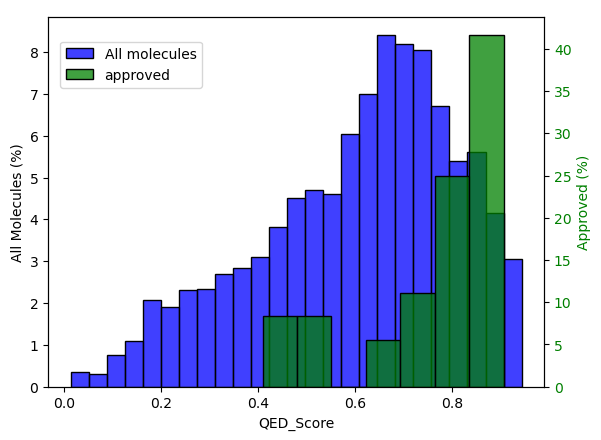

In [101]:
prop_to_plot = 'QED_Score'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot, stat='percent', ax=ax2, color='green', label='approved')
sns.histplot(data=cox2_ic50s, x=prop_to_plot, stat='percent', ax=ax1, color='blue',   label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.1,0.8));

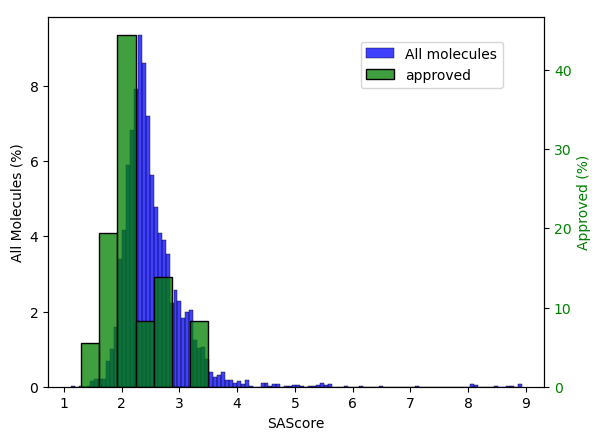

In [102]:
prop_to_plot = 'SAScore'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot,stat='percent', ax=ax2, color='green', label='approved')
sns.histplot(data=cox2_ic50s, x=prop_to_plot,stat='percent', ax=ax1, color='blue',   label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.6,0.8));

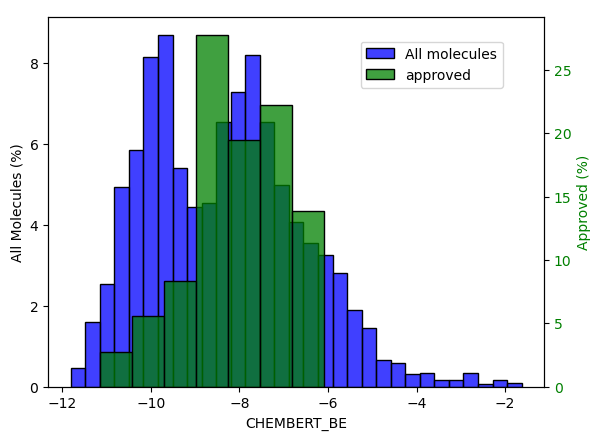

In [103]:
prop_to_plot = 'CHEMBERT_BE'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot,stat='percent', ax=ax2, color='green', label='approved')
sns.histplot(data=cox2_ic50s, x=prop_to_plot,stat='percent', ax=ax1, color='blue',   label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.6,0.8));

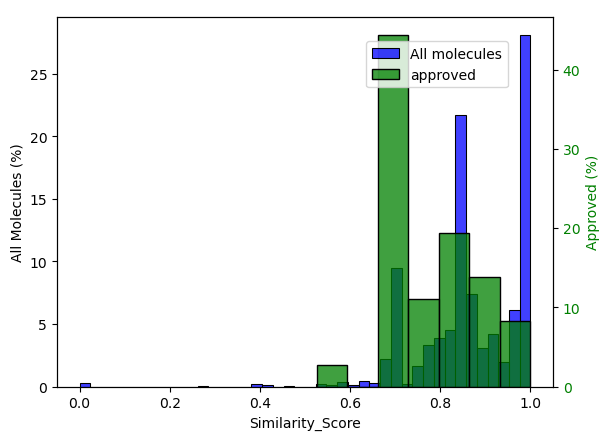

In [104]:
prop_to_plot = 'Similarity_Score'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot,stat='percent', ax=ax2, color='green', label='approved')
sns.histplot(data=cox2_ic50s, x=prop_to_plot,stat='percent', ax=ax1, color='blue',   label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.6,0.8));

In [105]:
# ADMET properties
# 'MUT_Risk', 'TOX_Risk', 'ADMET_Risk', '%Fb_hum-100.0'

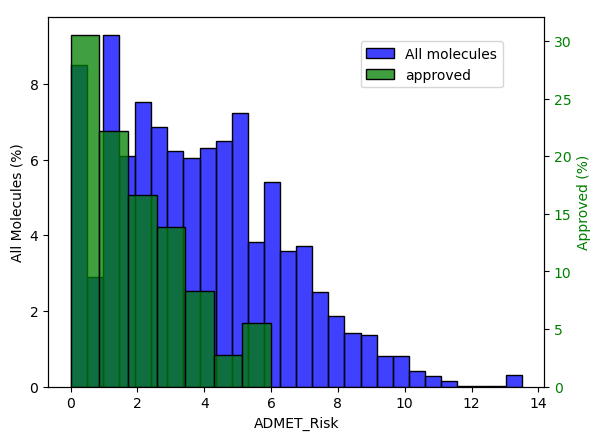

In [106]:
prop_to_plot = 'ADMET_Risk'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot,stat='percent', ax=ax2, color='green', label='approved')
sns.histplot(data=cox2_ic50s, x=prop_to_plot,stat='percent', ax=ax1, color='blue',   label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.6,0.8))

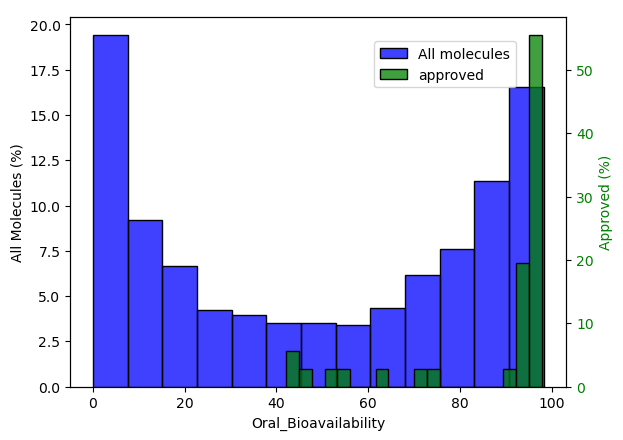

In [107]:
prop_to_plot = 'Oral_Bioavailability'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot,stat='percent', ax=ax2, color='green', label='approved')
sns.histplot(data=cox2_ic50s, x=prop_to_plot,stat='percent', ax=ax1, color='blue',   label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.6,0.8))

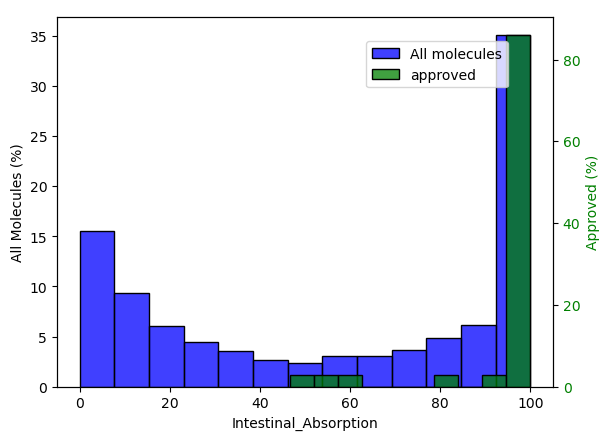

In [108]:
prop_to_plot = 'Intestinal_Absorption'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(data=approved,   x=prop_to_plot,stat='percent', ax=ax2, color='green', label='approved', bins=10)
sns.histplot(data=cox2_ic50s, x=prop_to_plot,stat='percent', ax=ax1, color='blue',  label='All molecules')
ax1.set_ylabel('All Molecules (%)')
ax2.set_ylabel('Approved (%)', color='green')
for tick in ax2.get_yticklabels(): tick.set_color('green')
fig.legend(loc=(0.6,0.8))

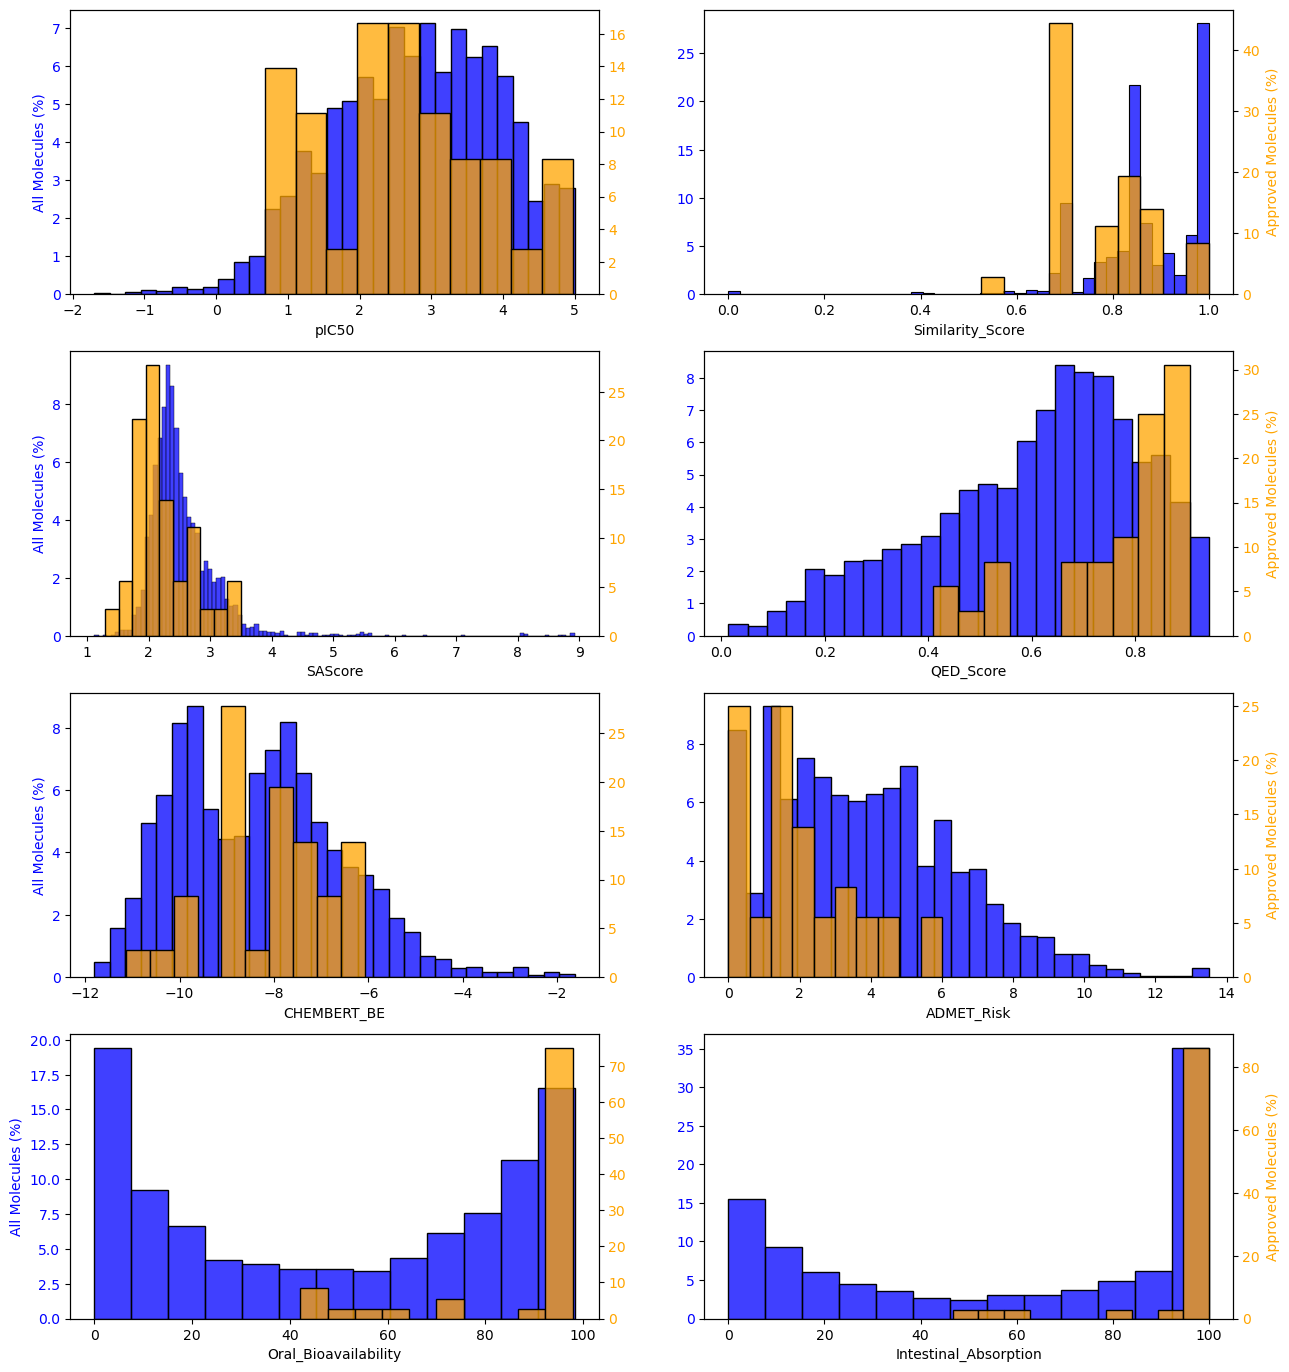

In [109]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15,17))
#ax2 = []
#for ax in ax1:
#    ax2.append(ax.twinx())

properties = [ 'pIC50','Similarity_Score', 'SAScore', 'QED_Score', 'CHEMBERT_BE', 'ADMET_Risk',
               'Oral_Bioavailability', 'Intestinal_Absorption']
col_i = 0
row_i = 0
for prop in properties:
    ax1 = ax[row_i,col_i]
    ax2 = ax1.twinx()
    sns.histplot(data=approved,   x=prop,stat='percent', ax=ax2, color='orange', label='approved', bins=10)
    sns.histplot(data=cox2_ic50s, x=prop,stat='percent', ax=ax1, color='blue',  label='All molecules')
    ax1.set_ylabel('All Molecules (%)' if col_i == 0 else '', color='blue' )
    ax2.set_ylabel('Approved Molecules (%)'      if col_i == 1 else '', color='orange' )
    for tick in ax1.get_yticklabels(): tick.set_color('blue')
    for tick in ax2.get_yticklabels(): tick.set_color('orange')
    
    col_i = col_i + 1
    if col_i > 1:
        col_i = 0
        row_i = row_i + 1
#ax[0,0].legend(loc=(0.6,0.8))

In [110]:
len(cox2_ic50s), len(approved)

(3590, 36)

In [111]:
approved.describe()

,Standard Value,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,8202.699806,2.585741,0.786799,2.238326,0.764256,-8.058934,1.965117,86.845000,95.323056
std,22013.465060,1.216342,0.101982,0.483251,0.140110,1.205382,1.626371,17.824033,13.037036
min,4.803000,0.681513,0.526316,1.295792,0.408716,-11.136306,0.000000,42.150000,46.720000
25%,36.750000,1.559386,0.710526,1.926052,0.728404,-8.722302,0.619782,92.145000,99.697500
50%,521.000000,2.716485,0.777473,2.147436,0.821600,-7.930749,1.704283,95.770000,99.960000
75%,2487.500000,3.394992,0.842105,2.465503,0.859567,-7.232438,2.959727,96.862500,99.990000
max,93300.000000,4.969882,1.000000,3.496406,0.905784,-6.079607,6.000000,97.860000,100.000000


<Axes: xlabel='Molecule Max Phase', ylabel='Count'>

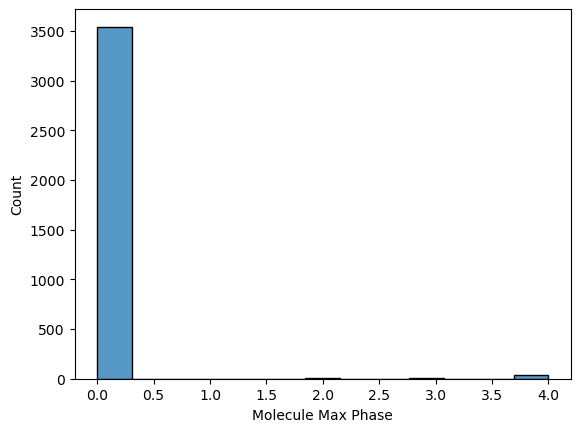

In [112]:
sns.histplot(data=cox2_ic50s, x='Molecule Max Phase')

In [113]:
# Celecoxib
cox2_ic50s[ cox2_ic50s['Molecule ChEMBL ID'] == 'CHEMBL118' ]

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Standard Type,Standard Relation,Standard Value,Standard Units,ROMol,Smiles,InChI Key,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
114,CHEMBL118,CELECOXIB,4,IC50,'=',40.0,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6b84243200>,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,RZEKVGVHFLEQIL-QVUQFMIFNA-N,1.60206,1.0,2.144357,0.754105,-11.136306,3.760878,51.24,56.06


# Dockings

## Prepare database for docking
* Prepare a database in SDF format that can be used with Glide.
* Alternatively, after preparation with LigPrep, any docking software coould be used.

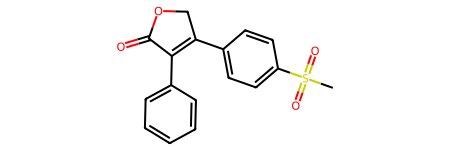

In [114]:
Chem.MolFromSmiles(cox2_ic50s[ cox2_ic50s['Molecule ChEMBL ID'] == 'CHEMBL122' ]['Smiles'].values[0])

In [115]:
cox2_ic50s.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'ROMol', 'Smiles', 'InChI Key', 'pIC50',
       'Similarity_Score', 'SAScore', 'QED_Score', 'CHEMBERT_BE', 'ADMET_Risk',
       'Oral_Bioavailability', 'Intestinal_Absorption'],
      dtype='object')

In [116]:
len(cox2_ic50s)

3590

In [117]:
len(cox2_ic50s['Molecule ChEMBL ID'].unique())

3590

In [118]:
PandasTools.WriteSDF(cox2_ic50s, 'ChEMBL31_cox2_ic50s.sdf', molColName='ROMol', idName='Molecule ChEMBL ID', properties=list(cox2_ic50s.columns))

Now, run dockings with any program. Here, we'll use Schrödinger Glide SP, and have the molecules aligned with the crystal structure of Celecoxib.


## Ligand Database

Running Schrödinger `LigPrep` with the database, with the options:
- Start with 3,590 unique molecules (ChEMBL IDs)
- pH: $ 7.4 \pm 1.0 $
- Desalt ; tautomers
- Generate Stereoisomers for all stereocenters without specified chirality

Results in 4,720 variants

**Docking**

*GlideSP with constraints*
- Location: `/home/seabra/work/li/elion_dev/tests/modular/hCOX2/chembl31/COX-2.prj/jobs/glide-dock_SP_5kir_VIOXX-core-2.5`
- Use core pattern
- Core: VIOXX from 5kir
- Core atoms: MCS
- Tolerance: 2.5A RMSD to core
With that, Glide could fit only 2,865 poses, from only 2,351 unique ChEMBLIDs.

```
All jobs succeeded: 4720 ligands done.
Writing 2,865 poses to glide-dock_SP_5kir_VIOXX-core-2.5_pv.maegz; database holds 2,865 poses.
Best docking score: -12.197

Some ligands were not docked for the following reasons:

   Count  Reason
--------  ------------------------------------------------------------
   1,330  GRID-ENERGY MIN FAILED
     401  NO POSES STORED FOR LIGAND
      59  NO GOOD POSES FOUND
      11  STRUCTURE HAS TOO MANY ATOMS OR BONDS
       3  INVALID ATOM(S), ETC.
       3  EMPTY MCS
       2  ROUGH POSE REFINE FAILED
```

*GlideSP without constraints*
- Location: `/home/seabra/work/li/elion_dev/tests/modular/hCOX2/chembl31/COX-2.prj/jobs/glide-dock_SP_5kir_no-constr/`
- Removed the constraints (all dockings "free")
- Stil same grid
- Got 3,373, from 2,726 unique ChEMBL IDs.

```
Writing 3,373 poses to glide-dock_SP_5kir_no-constr_pv.maegz; database holds 3,373 poses.
Best docking score: -12.584

Some ligands were not docked for the following reasons:

   Count  Reason
--------  ------------------------------------------------------------
     949  GRID-ENERGY MIN FAILED
     220  NO POSES STORED FOR LIGAND
     125  NO GOOD POSES FOUND
       3  INVALID ATOM(S), ETC.
       2  ROUGH POSE REFINE FAILED
```

Putting those together, we have 2,811 docked poses for unique ChEMBL IDs, we could recover 460 new poses, so 779 molecules could not be docked into the site.


In [119]:
glide = pd.read_csv('glide-docking-all.csv', dtype={"Title":str, "Job Name":str, "docking score":np.float64, "glide gscore":np.float64, "glide emodel":np.float64})
glide.rename(columns={'Title':'Molecule ChEMBL ID'}, inplace=True)

In [120]:
glide = glide.merge(cox2_ic50s, on=['Molecule ChEMBL ID'])

In [121]:
len(cox2_ic50s),len(cox2_ic50s['Molecule ChEMBL ID'].unique())

(3590, 3590)

In [122]:
cox2_ic50s['Molecule Max Phase'].value_counts()

Molecule Max Phase
0    3543
4      36
3       7
2       4
Name: count, dtype: int64

In [123]:
glide.head()

,Molecule ChEMBL ID,Job Name,docking score,glide gscore,glide emodel,Molecule Name,Molecule Max Phase,Standard Type,Standard Relation,Standard Value,Standard Units,ROMol,Smiles,InChI Key,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
0,CHEMBL1766298,glide-dock_SP_5kir_no-constr,-12.583680,-12.583680,-113.783816,NaN,0,IC50,'=',1000.0,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6afc0bf2e0>,NS(=O)(=O)c1ccc(-n2nc(CCNC(=O)Nc3cccc(C(F)(F)F...,UUGVSHPGHRTCIE-KUZQTNIQNA-N,3.000000,1.000000,2.420017,0.324960,-11.007765,6.085058,39.85,47.78
1,CHEMBL1766299,glide-dock_SP_5kir_no-constr,-12.439232,-12.439232,-107.683520,NaN,0,IC50,'=',700.0,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6afc04a350>,NS(=O)(=O)c1ccc(-n2nc(CCCNC(=O)Nc3cccc(C(F)(F)...,RTBLKQRJBQTBLS-WYSJODPONA-N,2.845098,1.000000,2.462630,0.272274,-11.250158,9.228766,36.84,46.86
2,CHEMBL4063233,glide-dock_SP_5kir_VIOXX-core-2.5,-12.197296,-12.197296,-107.973172,NaN,0,IC50,'=',1430.0,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6afc0a40b0>,NS(=O)(=O)c1ccc(-n2nc(C(=O)OCCOc3cc(=O)oc4cccc...,JDXXMVLLXMDCMQ-XIPNIRHDNA-N,3.155336,1.000000,2.618608,0.167529,-11.282704,8.666667,2.66,3.68
3,CHEMBL94494,glide-dock_SP_5kir_no-constr,-12.185471,-12.185471,-81.177225,NaN,0,IC50,'=',16.0,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6afc1033c0>,Cc1cc2c(cc1F)-c1c(c(C(F)(F)F)nn1-c1ccc(S(N)(=O...,DADHJCHABCTJSK-TWSYTRIPNA-N,1.204120,0.974359,2.902591,0.600719,-11.376935,6.347246,12.21,15.28
4,CHEMBL1766301,glide-dock_SP_5kir_VIOXX-core-2.5,-12.094499,-12.094499,-100.098712,NaN,0,IC50,'=',2800.0,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6afc046ac0>,Cc1ccc(-c2cc(CCCNC(=O)Nc3cccc(C(F)(F)F)c3)nn2-...,KPZWJSMDQMZGAZ-RBZXKLCMNA-N,3.447158,1.000000,2.511018,0.255881,-11.058530,9.664704,25.75,35.16


In [124]:
# Reference: VIOXX
glide[ glide['Molecule ChEMBL ID'] == 'CHEMBL122' ]

,Molecule ChEMBL ID,Job Name,docking score,glide gscore,glide emodel,Molecule Name,Molecule Max Phase,Standard Type,Standard Relation,Standard Value,Standard Units,ROMol,Smiles,InChI Key,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
753,CHEMBL122,glide-dock_SP_5kir_VIOXX-core-2.5,-9.969839,-9.969839,-78.581704,ROFECOXIB,4,IC50,'=',500.0,nM,<rdkit.Chem.rdchem.Mol object at 0x7f6afc102200>,CS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)OC2)cc1,RZJQGNCSTQAWON-UHFFFAOYNA-N,2.69897,1.0,2.124871,0.816995,-9.871007,1.705649,44.69,46.72


In [125]:
glide.columns

Index(['Molecule ChEMBL ID', 'Job Name', 'docking score', 'glide gscore',
       'glide emodel', 'Molecule Name', 'Molecule Max Phase', 'Standard Type',
       'Standard Relation', 'Standard Value', 'Standard Units', 'ROMol',
       'Smiles', 'InChI Key', 'pIC50', 'Similarity_Score', 'SAScore',
       'QED_Score', 'CHEMBERT_BE', 'ADMET_Risk', 'Oral_Bioavailability',
       'Intestinal_Absorption'],
      dtype='object')

Text(0.5, 0, 'GlideSP Score (kcal/mol)')

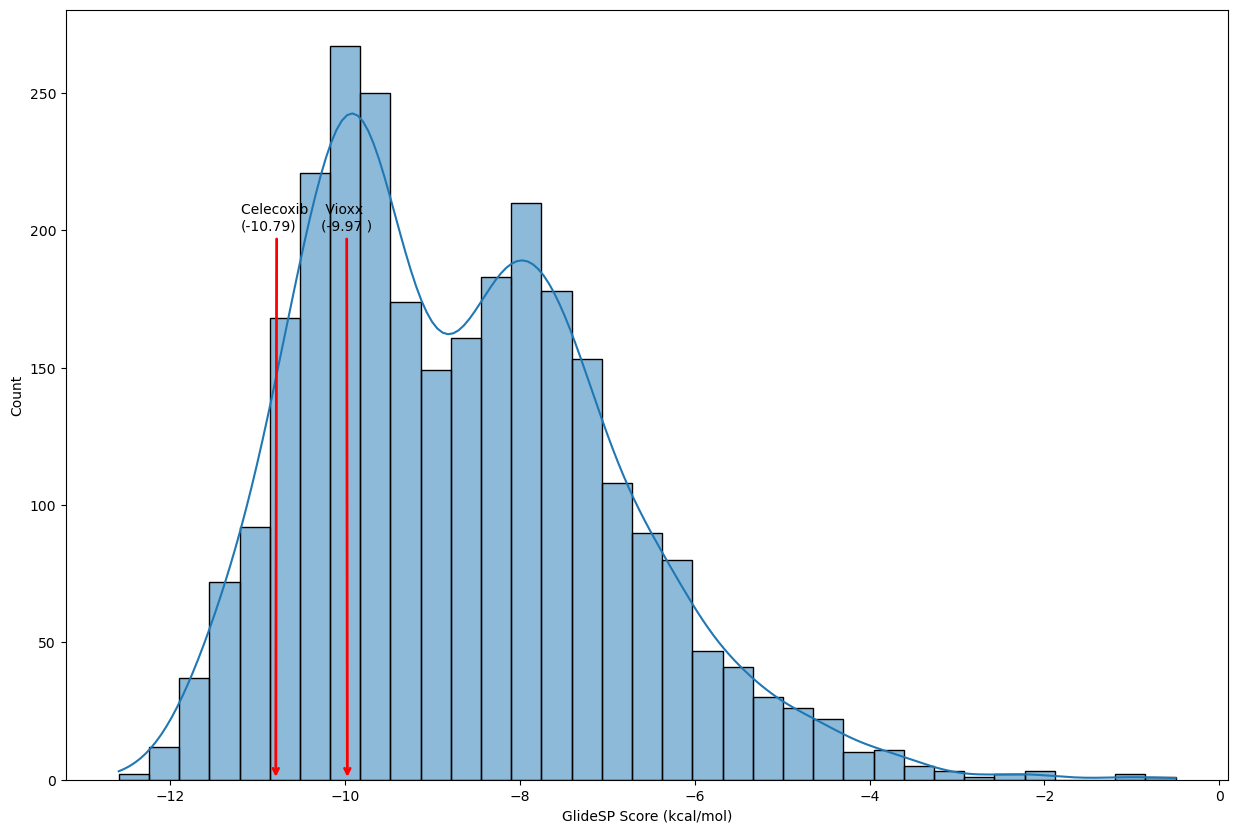

In [126]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=glide, x='docking score', kde=True, ax=ax)
vioxx_score = glide[ glide['Molecule ChEMBL ID'] == 'CHEMBL122' ]['docking score'].values[0]
plt.annotate(f"{'Vioxx':^8s}\n({vioxx_score:^6.2f})", (vioxx_score,0), (vioxx_score-0.3,200), 
             arrowprops={'arrowstyle':'->', 'lw':2.0, 'color':'red'})
celecoxib_score = glide[ glide['Molecule ChEMBL ID'] == 'CHEMBL118' ]['docking score'].values[0]
plt.annotate(f"{'Celecoxib':^10s}\n({celecoxib_score:^6.2f})", (celecoxib_score,0), (celecoxib_score-0.4,200), 
             arrowprops={'arrowstyle':'->', 'lw':2.0, 'color':'red'})
ax.set_xlabel("GlideSP Score (kcal/mol)")

In [127]:
glide[ glide['Molecule ChEMBL ID'] == 'CHEMBL118' ]['docking score'].values[0]

-10.788160199338

In [128]:
glide.corr(numeric_only=True)

,docking score,glide gscore,glide emodel,Standard Value,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
docking score,1.000000,0.997954,0.819808,0.151484,0.340727,-0.533856,0.056617,-0.170336,0.950894,0.075461,0.135063,0.206420
glide gscore,0.997954,1.000000,0.823107,0.153359,0.341262,-0.535779,0.055099,-0.170369,0.948999,0.078001,0.133686,0.205184
glide emodel,0.819808,0.823107,1.000000,0.141634,0.292867,-0.438517,0.107571,-0.183297,0.795410,0.173519,0.033214,0.098285
Standard Value,0.151484,0.153359,0.141634,1.000000,0.611870,-0.078649,0.001195,0.003515,0.159345,-0.059690,0.064489,0.090735
pIC50,0.340727,0.341262,0.292867,0.611870,1.000000,-0.166003,-0.014231,-0.069834,0.355033,-0.117270,0.195665,0.252108
Similarity_Score,-0.533856,-0.535779,-0.438517,-0.078649,-0.166003,1.000000,-0.224126,-0.033952,-0.548317,-0.039106,-0.141062,-0.182864
SAScore,0.056617,0.055099,0.107571,0.001195,-0.014231,-0.224126,1.000000,-0.017209,0.056279,-0.028475,0.181154,0.162448
QED_Score,-0.170336,-0.170369,-0.183297,0.003515,-0.069834,-0.033952,-0.017209,1.000000,-0.195583,-0.525644,0.274189,0.215301
CHEMBERT_BE,0.950894,0.948999,0.795410,0.159345,0.355033,-0.548317,0.056279,-0.195583,1.000000,0.080503,0.132285,0.207720
ADMET_Risk,0.075461,0.078001,0.173519,-0.059690,-0.117270,-0.039106,-0.028475,-0.525644,0.080503,1.000000,-0.589188,-0.528958


In [129]:
glide.describe()

,docking score,glide gscore,glide emodel,Standard Value,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
count,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000
mean,-8.683068,-8.712934,-56.312806,6378.354597,2.732366,0.874548,2.475027,0.657098,-8.620174,3.205292,53.491719,61.580434
std,1.748414,1.736625,21.874652,15264.442379,1.161159,0.125074,0.460843,0.172354,1.676981,2.154758,34.924346,37.752462
min,-12.583680,-12.583680,-113.783816,0.069980,-1.155026,0.000000,1.116749,0.074184,-11.806853,0.000000,0.092100,0.620000
25%,-10.022665,-10.037860,-74.751515,79.415000,1.899903,0.815789,2.188849,0.557528,-9.951435,1.436365,16.030000,20.185000
50%,-8.877484,-8.905708,-55.947124,560.000000,2.748188,0.868421,2.385278,0.683042,-8.809656,3.000000,61.520000,75.690000
75%,-7.526560,-7.577987,-39.441420,4260.000000,3.629405,1.000000,2.649308,0.781873,-7.529220,4.791708,87.510000,99.320000
max,-0.500680,-0.500680,20.879152,100000.000000,5.000000,1.000000,5.624597,0.942618,-1.867487,10.452073,98.280000,100.000000


In [130]:
len(glide[ glide['Molecule Max Phase'] > 3])

34

In [131]:
glide['Molecule Max Phase'].value_counts()

Molecule Max Phase
0    2768
4      34
3       6
2       3
Name: count, dtype: int64

In [132]:
glide[ glide['Molecule Max Phase'] > 3].describe()

,docking score,glide gscore,glide emodel,Standard Value,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,-8.027429,-8.041797,-49.533544,7436.967441,2.519308,0.787559,2.224395,0.779646,-8.050655,1.730175,87.861176,95.242353
std,1.141599,1.146530,16.872522,21850.156055,1.198981,0.103811,0.489747,0.127623,1.235468,1.334775,16.874726,13.397699
min,-10.788160,-10.788160,-81.393983,4.803000,0.681513,0.526316,1.295792,0.408716,-11.136306,0.000000,42.150000,46.720000
25%,-8.617332,-8.670399,-58.418803,30.250000,1.474038,0.710526,1.918404,0.745012,-8.722302,0.539927,92.472500,99.760000
50%,-8.174040,-8.174040,-48.745474,500.000000,2.698970,0.777473,2.146445,0.823247,-7.930749,1.653220,95.800000,99.965000
75%,-7.313514,-7.313514,-38.592865,2075.000000,3.295507,0.842105,2.426889,0.859892,-7.216286,2.574582,96.887500,99.990000
max,-5.706077,-5.706077,-13.541274,93300.000000,4.969882,1.000000,3.496406,0.905784,-6.079607,4.588024,97.860000,100.000000


In [133]:
glide.columns

Index(['Molecule ChEMBL ID', 'Job Name', 'docking score', 'glide gscore',
       'glide emodel', 'Molecule Name', 'Molecule Max Phase', 'Standard Type',
       'Standard Relation', 'Standard Value', 'Standard Units', 'ROMol',
       'Smiles', 'InChI Key', 'pIC50', 'Similarity_Score', 'SAScore',
       'QED_Score', 'CHEMBERT_BE', 'ADMET_Risk', 'Oral_Bioavailability',
       'Intestinal_Absorption'],
      dtype='object')

In [134]:
approved = glide[ glide['Molecule Max Phase'] > 3 ]
approved.describe()

,docking score,glide gscore,glide emodel,Standard Value,pIC50,Similarity_Score,SAScore,QED_Score,CHEMBERT_BE,ADMET_Risk,Oral_Bioavailability,Intestinal_Absorption
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,-8.027429,-8.041797,-49.533544,7436.967441,2.519308,0.787559,2.224395,0.779646,-8.050655,1.730175,87.861176,95.242353
std,1.141599,1.146530,16.872522,21850.156055,1.198981,0.103811,0.489747,0.127623,1.235468,1.334775,16.874726,13.397699
min,-10.788160,-10.788160,-81.393983,4.803000,0.681513,0.526316,1.295792,0.408716,-11.136306,0.000000,42.150000,46.720000
25%,-8.617332,-8.670399,-58.418803,30.250000,1.474038,0.710526,1.918404,0.745012,-8.722302,0.539927,92.472500,99.760000
50%,-8.174040,-8.174040,-48.745474,500.000000,2.698970,0.777473,2.146445,0.823247,-7.930749,1.653220,95.800000,99.965000
75%,-7.313514,-7.313514,-38.592865,2075.000000,3.295507,0.842105,2.426889,0.859892,-7.216286,2.574582,96.887500,99.990000
max,-5.706077,-5.706077,-13.541274,93300.000000,4.969882,1.000000,3.496406,0.905784,-6.079607,4.588024,97.860000,100.000000


In [135]:
approved.to_csv('COX-2_ChEMBL31_Approved.csv', index=None)

In [136]:
!pwd

/home/seabra/work/li/elion_dev/tests/modular/hCOX2/chembl31


## Save data for CHEM-BERT model

In [137]:
Path('CHEM-BERT_ft/glide_scores/input/').mkdir(exist_ok=True, parents=True)
glide[['Smiles','docking score']].to_csv('CHEM-BERT_ft/glide_scores/input/dataset.csv', index=None)

# CHEM-BERT Model

In [138]:
chembert_progress = pd.read_csv("/home/seabra/work/li/elion_dev/tests/modular/hCOX2/qsar_model/chembl31/CHEM-BERT_ft/glide_scores/chembert/result.csv")
chembert_progress["Epoch"] = chembert_progress["Epoch"] + 1
chembert_progress.head()

,Epoch,Train_loss,Valid_loss,Valid_score
0,1,29.874730,3.015377,1.332763
1,2,2.079471,1.414241,0.890771
2,3,1.338002,1.189703,0.786717
3,4,1.055795,0.926225,0.721067
4,5,0.882752,0.902567,0.695949


In [139]:
# CHEM-BERT generated data
chembert = pd.read_csv('/home/seabra/work/li/elion_dev/tests/modular/hCOX2/qsar_model/chembl31/CHEM-BERT_ft/glide_scores/dataset_Finetuned_model_15.csv')
chembert.head()

,SMILES,GlideSP_Score,Prediction
0,CN(C)c1ccc(-c2cc(F)c(F)cc2-c2ccc(S(N)(=O)=O)cc...,-11.52,-11.81
1,CN(C)c1ccc(-c2c(-c3ccc(S(N)(=O)=O)cc3)ccc(F)c2...,-11.76,-11.73
2,Cc1cc(-c2c(-c3ccc(S(N)(=O)=O)cc3)ccc(F)c2F)ccc1F,-11.96,-11.65
3,Cc1ccc(-c2c(-c3ccc(S(N)(=O)=O)cc3)ccc(F)c2F)cc1Cl,-11.89,-11.65
4,Cc1cc(-c2c(-c3ccc(S(N)(=O)=O)cc3)ccc(F)c2F)ccc1Cl,-11.63,-11.65


In [140]:
chembert.corr(numeric_only=True)

,GlideSP_Score,Prediction
GlideSP_Score,1.000000,0.951025
Prediction,0.951025,1.000000


In [141]:
len(chembert.SMILES.unique())

2810

In [142]:
chembert.describe()

,GlideSP_Score,Prediction
count,2810.000000,2810.000000
mean,-8.683068,-8.620438
std,1.748702,1.677159
min,-12.580000,-11.810000
25%,-10.020000,-9.950000
50%,-8.880000,-8.810000
75%,-7.530000,-7.530000
max,-0.500000,-1.870000


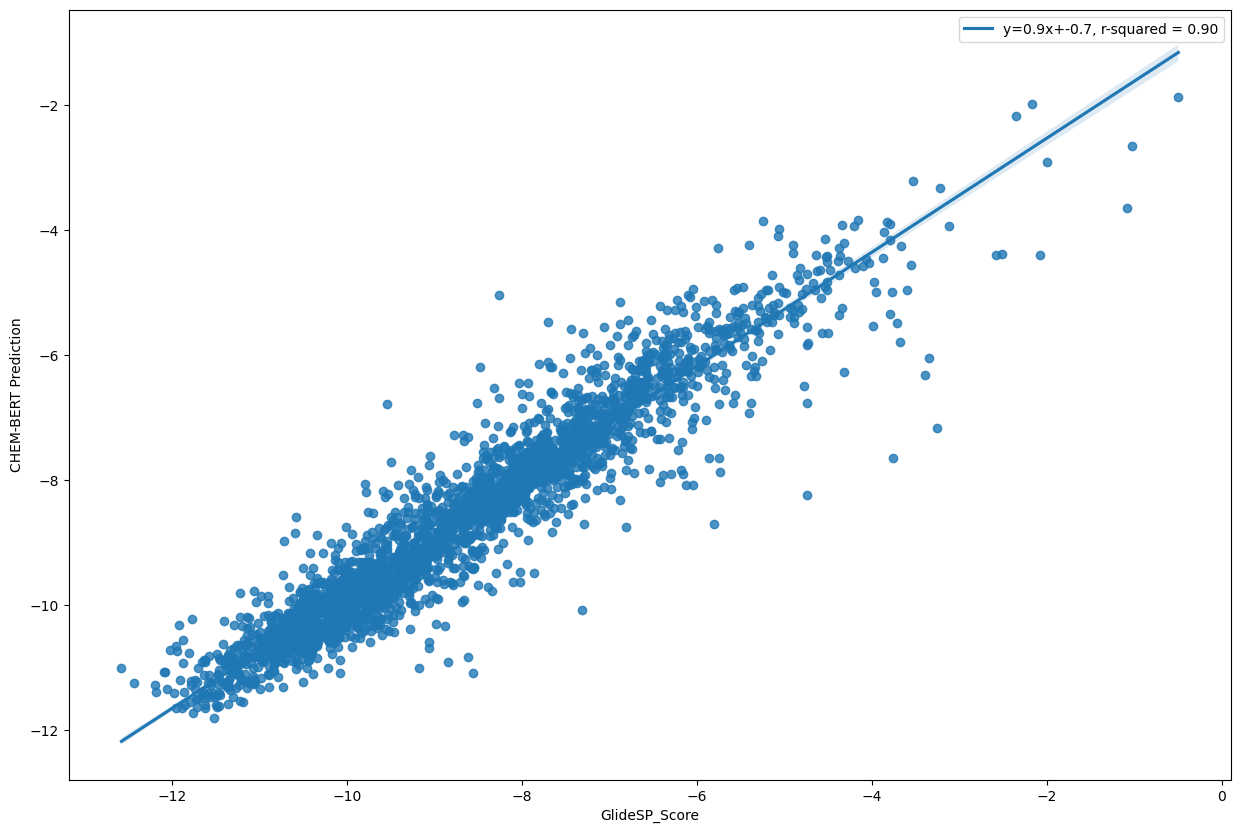

In [143]:
fig, ax = plt.subplots(figsize=(15,10))
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(chembert.GlideSP_Score, chembert.Prediction)

# use line_kws to set line label for legend
g = sns.regplot(data=chembert, x='GlideSP_Score', y='Prediction', ci=95, ax=ax, 
                line_kws={'label':f"y={slope:.1f}x+{intercept:.1f}, r-squared = {r_value**2:.2f}"})
ax.set_ylabel('CHEM-BERT Prediction')
ax.legend()

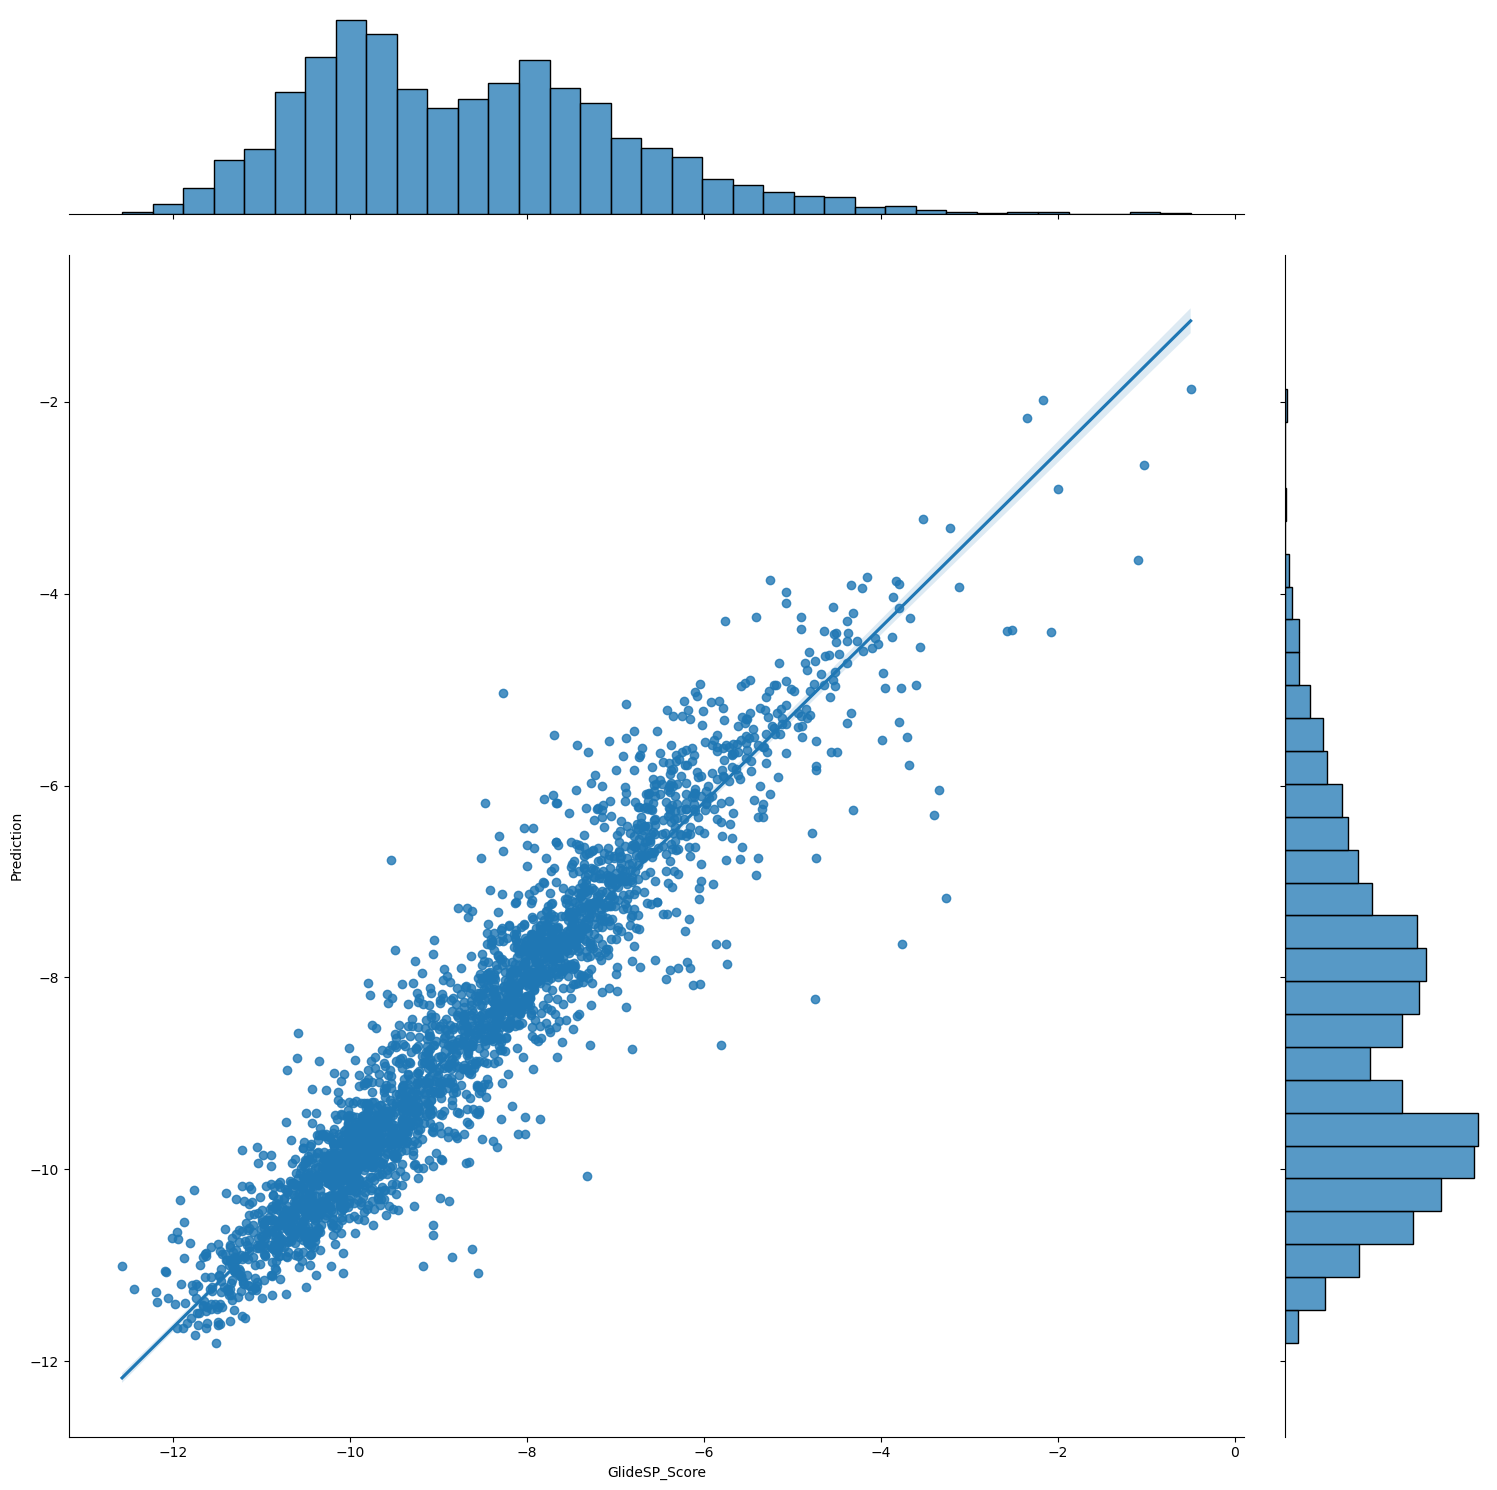

In [144]:
#fig, ax = plt.subplots(figsize=(15,10))
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(chembert.GlideSP_Score, chembert.Prediction)

# use line_kws to set line label for legend
#g = sns.regplot(data=chembert, x='GlideSP_Score', y='Prediction', ci=95, ax=ax, 
#                line_kws={'label':f"y={slope:.1f}x+{intercept:.1f}, r-squared = {r_value**2:.2f}"})

g=sns.JointGrid(data=chembert, x='GlideSP_Score', y='Prediction', height=15)
g.plot_joint(sns.regplot)
g.plot_marginals(sns.histplot)


In [145]:
# Test Set
chembert_test = pd.read_csv("/home/seabra/work/li/elion_dev/tests/modular/hCOX2/qsar_model/chembl31/CHEM-BERT_ft/glide_scores/chembert/test.smi")
chembert_test = pd.merge(chembert_test,chembert, how="inner", on="SMILES")
chembert_test.head()

,SMILES,LABELS,GlideSP_Score,Prediction
0,N#Cc1c(/N=C/c2cccs2)c(C(=O)Nc2ccc(Br)cc2)n2c1CCC2,-7.787304,-7.79,-6.76
1,CC1(C)OC(=O)C(Oc2cc(F)cc(F)c2)=C1c1ccc(S(C)(=O...,-8.336608,-8.34,-9.77
2,CS(=O)(=O)c1ccc(-c2c(-c3ccc(F)cc3)nc3sccn23)cc1,-10.580969,-10.58,-10.25
3,Cn1c(Cl)c(Cl)c(-c2ccc(F)cc2)c1-c1ccc(S(C)(=O)=...,-10.474921,-10.47,-10.21
4,O=c1c2ccccc2nc2n1CCc1c-2[nH]c2ccccc12,-8.772236,-8.77,-8.64


In [146]:
# Validation Set
chembert_valid = pd.read_csv("/home/seabra/work/li/elion_dev/tests/modular/hCOX2/qsar_model/chembl31/CHEM-BERT_ft/glide_scores/chembert/valid.smi")
chembert_valid = pd.merge(chembert_valid,chembert, how="inner", on="SMILES")
chembert_valid.head()

,SMILES,LABELS,GlideSP_Score,Prediction
0,CCOC(=O)C1=C(N)n2c(=O)c3ncccc3c(=O)n2C1c1ccccc1O,-9.677658,-9.68,-9.01
1,COc1ccc(/C=N/c2ccc(S(N)(=O)=O)cc2)cc1OC,-6.255937,-6.26,-6.26
2,O=C1NC(=O)/C(=C/c2ccc(OCc3cn(Cc4ccccc4)nn3)cc2)S1,-6.589951,-6.59,-5.81
3,COc1ccc2c(c1)c(CC(=O)OC(C)C)c(C)n2C(=O)c1ccc(C...,-7.288886,-7.29,-8.70
4,CC(C(=O)O)c1ccc(-c2cccc(OC(=O)NC3CC3)c2)c(F)c1,-3.989503,-3.99,-5.53


In [147]:
# Training Set
chembert_train = pd.read_csv("/home/seabra/work/li/elion_dev/tests/modular/hCOX2/qsar_model/chembl31/CHEM-BERT_ft/glide_scores/chembert/train.smi")
chembert_train = pd.merge(chembert_train,chembert, how="inner", on="SMILES")
chembert_train.head()

,SMILES,LABELS,GlideSP_Score,Prediction
0,CS(=O)(=O)c1ccc(-c2cc3c(cc2C=C2CCCCCC2)OCO3)cc1,-9.888220,-9.89,-9.69
1,O=C(O)C1=Cc2cc(Cl)cc(-c3ccccc3)c2OC1C(F)(F)F,-9.519556,-9.52,-9.66
2,CC(C(=O)O)c1ccc(-c2ccccc2)c(F)c1,-8.830859,-8.83,-8.88
3,CS(=O)(=O)c1ccc(/C=C(/C(=O)O)c2ccc(-c3ccc(F)cc...,-7.342590,-7.34,-7.40
4,Cc1nc(-c2ccccc2)c(-c2ccc(S(N)(=O)=O)cc2)s1,-10.331774,-10.33,-10.34


In [148]:
print("Training Set:   ", len(chembert_train))
print("Validation Set: ", len(chembert_valid))
print("Testing Set:    ", len(chembert_test))
print("Total Size:     ", len(chembert_train) + len(chembert_valid) + len(chembert_test))
print("All data:       ", len(chembert))

Training Set:    2248
Validation Set:  282
Testing Set:     281
Total Size:      2811
All data:        2810


In [149]:
# There's ONE SMILES string that appear in both the testing and validation sets
l1 = list(chembert_test.SMILES.values)
l2 = list(chembert_valid.SMILES.values)
print(len(l1 + l2)), print((set(l1)&set(l2)))

563
{'O=C(c1ccccc1)c1ccc2n1CCC2C(=O)O'}


(None, None)

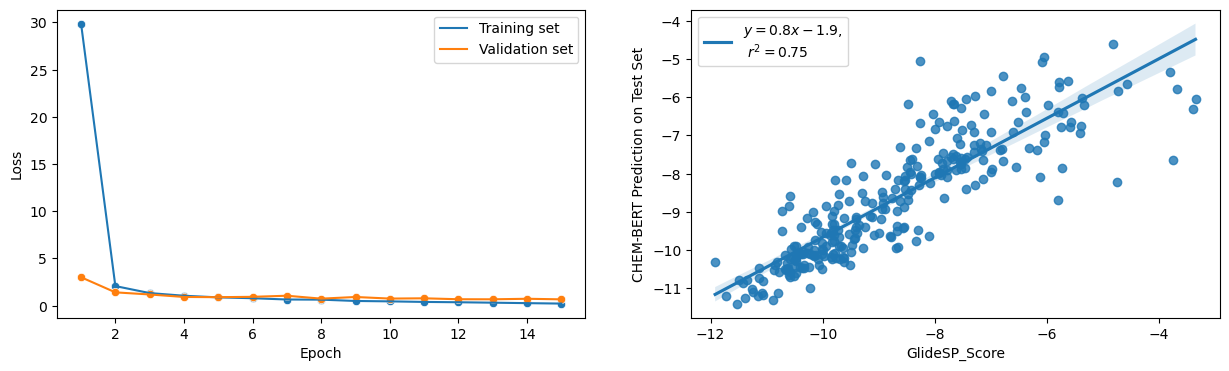

In [150]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,4))
from scipy import stats

# Training Progress
g = sns.lineplot(data=chembert_progress, x="Epoch", y="Train_loss", label="Training set", ax=ax[0], markers=True, sizes=600)
g = sns.lineplot(data=chembert_progress, x="Epoch", y="Valid_loss", label="Validation set", ax=ax[0], markers=True, sizes=600)
g = sns.scatterplot(data=chembert_progress, x="Epoch", y="Train_loss", ax=ax[0], markers=True, sizes=600)
g = sns.scatterplot(data=chembert_progress, x="Epoch", y="Valid_loss", ax=ax[0], markers=True, sizes=600)
ax[0].set_ylabel("Loss")
ax[0].legend()

# Test Set regression
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(chembert_test.GlideSP_Score, chembert_test.Prediction)

# use line_kws to set line label for legend
g = sns.regplot(data=chembert_test, x='GlideSP_Score', y='Prediction', ci=95, ax=ax[1], 
                line_kws={'label':f"$y={slope:.1f}x {intercept:.1f}$,\n $r^2 = {r_value**2:.2f}$"})
ax[1].set_ylabel('CHEM-BERT Prediction on Test Set')
ax[1].legend()

In [151]:
chembert_progress.loc[ chembert_progress.Valid_loss == chembert_progress.Valid_loss.min() ]

,Epoch,Train_loss,Valid_loss,Valid_score
14,15,0.225324,0.674443,0.592238


# Save database

In [153]:
cox2_ic50s.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'ROMol', 'Smiles', 'InChI Key', 'pIC50',
       'Similarity_Score', 'SAScore', 'QED_Score', 'CHEMBERT_BE', 'ADMET_Risk',
       'Oral_Bioavailability', 'Intestinal_Absorption'],
      dtype='object')

In [154]:
glide.columns

Index(['Molecule ChEMBL ID', 'Job Name', 'docking score', 'glide gscore',
       'glide emodel', 'Molecule Name', 'Molecule Max Phase', 'Standard Type',
       'Standard Relation', 'Standard Value', 'Standard Units', 'ROMol',
       'Smiles', 'InChI Key', 'pIC50', 'Similarity_Score', 'SAScore',
       'QED_Score', 'CHEMBERT_BE', 'ADMET_Risk', 'Oral_Bioavailability',
       'Intestinal_Absorption'],
      dtype='object')

In [155]:
set(glide.columns) - set(cox2_ic50s.columns)

{'Job Name', 'docking score', 'glide emodel', 'glide gscore'}

In [156]:
len(glide),len(cox2_ic50s)

(2811, 3590)

In [157]:
cox2_ic50s.to_pickle("cox2_ic50s.pkl")

In [158]:
glide.to_pickle("cox2_ic50s_glide.pkl")